In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


from plotting_functions import *
import math
import csv
import time
from math import log
import networkx as nx
from os import listdir
import random
import io
from io import StringIO
import codecs
import math
from os.path import isfile, join
#from geopy.distance.geodesic import vincenty
# In[2]:
from math import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset, InsetPosition

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import *

# geometric distribution for trials prob(n) = p q^(n-1) where p is success probability
F_geo = lambda x,p: np.floor(np.log(1-x)/np.log(1-p))
f = lambda x,p: p* (1-p)**(x-1)
# photon transmission probability in fiber (i.e., 0.2dB/km)
Trans = lambda x: 10**(-0.2*x/10)
# Binary Shanon entropy
def h(p_list):
    y_list = np.zeros(len(p_list))
    for i,p in enumerate(p_list):
        if p<1e-6 or (1-p)<1e-6:
            y_list[i]= 0
        else:
            y_list[i]= -p*np.log2(p)-(1-p)*np.log2(1-p)
    return y_list

In [3]:
def one_repeater_cutoff(Le2e,τ_cut):

    # constants
    c = 2e5 # speed of light in fiber [km/s]
    p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware
    
    def T_parallel_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link, Nmax=100000):
        """ calculates the performance of parallel scheme with one repeater
        inputs:
            L1,L2: elementary link lengths *** works for arbitrary L1,L2 ****
            τ_cut: cut-off time
            τ_coh: coherence time of quantum memories
            mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
            entanglement swapping error
            F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
            Nmax: ensemble size for averaging
        outputs:
            Raw_rate: 1/ expected value of total time for e2e entanglement delivery
            *** application specific quantities:
            skr: secret key rate for qkd (does not include idle times of end memories)
            F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
        """
        Nmax = int(Nmax) # to make sure Nmax is an integer
        τ1 = L1/c
        τ2 = L2/c
        p1 = p_link*Trans(L1)
        p2 = p_link*Trans(L2)
        # N1 = F_geo(np.random.uniform(low=p1, high=1, size=(Nmax,)),p1)
        # N2 = F_geo(np.random.uniform(low=p2, high=1, size=(Nmax,)),p2)
        N1 = F_geo(np.random.rand(Nmax),p1)
        N2 = F_geo(np.random.rand(Nmax),p2)
        Ts = np.max(np.array([(2*N1-1)*τ1,2*N2*τ2]),axis=0) # swap moment
        t1L = Ts-(2*N1-1)*τ1 # elapsed time of leftside repeater's memory 
        t1R = Ts-2*(N2-1)*τ2 # elapsed time of rightside repeater's memory 
        indsL = np.argwhere( t1L <= τ_cut )[:,0]
        indsR = np.argwhere( t1R <= τ_cut )[:,0]
        succ_inds = np.intersect1d(indsL,indsR)
        T_succ = np.sum(Ts[succ_inds]+ τ1) 
        fail_inds = list(set(list(range(Nmax)))-set(succ_inds))
        # L_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 <= 2*N2[fail_inds]*τ2 ).shape[0]
        # R_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 > 2*N2[fail_inds]*τ2 ).shape[0]
        # T_fail = (2*τ1/p1 + τ_cut)*L_runs + (2*τ2*(1/p2-1)+τ1 + τ_cut)*R_runs
        # T_fail = (2*τ1/p1 + τ_cut)*(Nmax-len(succ_inds))
        L_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 <= 2*N2[fail_inds]*τ2 )[:,0]
        R_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 > 2*N2[fail_inds]*τ2 )[:,0]
        # print(list(np.array(fail_inds)[L_runs]))
        left_mem_on_idx = list(np.array(fail_inds)[L_runs])
        right_mem_on_idx = list(np.array(fail_inds)[R_runs])
        T_elapsed_left = 2*N1[left_mem_on_idx]*τ1 + τ_cut
        T_elapsed_right = 2*(N2[right_mem_on_idx]-1)*τ2 +τ1+ τ_cut
        T_fail = np.sum(T_elapsed_left)+np.sum(T_elapsed_right)
    
        mean_succ =  T_succ/len(succ_inds)
        mean_fail = T_fail/len(fail_inds)
        # print("Mean succ time: ", T_succ/len(succ_inds))
        # print("Mean fail time: ", T_fail/len(fail_inds))
        # print("success prob", len(succ_inds)/Nmax)
        # print("fail prob", len(fail_inds)/Nmax)
    
        raw_rate = len(succ_inds)/(T_succ+T_fail)
        t_idle_qkd = t1L + t1R
        f_memory_qkd = np.mean(np.exp(- t_idle_qkd[succ_inds]/τ_coh) )
        N_links = 2
        mu_e2e = mu_link**(2*N_links-1)
        # secret key rate calculations
        f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
        ex = (1 - mu_e2e)/2
        ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
        skr = raw_rate * (1-h([ex])-h([ez]))
        #  fidelity of e2e Bell pairs
        tA = Ts+ τ1 -2*(N1-1)*τ1 # elapsed time of A's memory 
        tB = Ts+ τ1 -(2*N2-1)*τ2 # elapsed time of B's memory 
        t_idle_bell = tA + tB + t1L + t1R
        mean_sender = tA[succ_inds].mean()
        mean_receiver = tB[succ_inds].mean()
        f_memory_bell = np.mean(np.exp(- t_idle_bell[succ_inds]/τ_coh) )
        f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
        F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
        
        # print(f"t1L = {np.mean(t1L)}, t1R = {np.mean(t1R)}")
        # print(f"t1L = {np.mean(t1L[succ_inds])}, t1R = {np.mean(t1R[succ_inds])}")
        return raw_rate, skr, F_e2e, mean_succ, mean_fail, mean_sender, mean_receiver
    
    def T_sequential_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link):
        """ calculates the performance of parallel scheme with one repeater
        inputs:
            L1,L2: elementary link lengths *** works for arbitrary L1,L2 ****
            τ_cut: cut-off time
            τ_coh: coherence time of quantum memories
            mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
            entanglement swapping error
            F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        outputs:
            Raw_rate: 1/ expected value of total time for e2e entanglement delivery
            *** application specific quantities:
            skr: secret key rate for qkd (does not include idle times of end memories)
            F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
        """
        τ1 = L1/c
        τ2 = L2/c
        m = int(τ_cut/(2*τ2))
        p1 = p_link*Trans(L1)
        p2 = p_link*Trans(L2)
        # Q2m = (1-p2)**m
        P2m = 1- (1-p2)**m
        Nm = lambda x: (1-(1+m*x)*(1-x)**m)/x
        Tm = 2*τ1/(p1*P2m) +  (1/P2m-1)*τ_cut +Nm(p2)/P2m*2*τ2 
    
        raw_rate = 1/(Tm)
        # t1L = Nm(p2)/P2m*2*τ2
        # t1R = 2*τ2
        f_memory_qkd = p2*np.exp(-4*τ2/τ_coh)/ P2m * (1-(1-p2)**m * np.exp(-2*m*τ2/τ_coh))/(1- (1-p2)*np.exp(-2*τ2/τ_coh) ) 
        N_links = 2
        mu_e2e = mu_link**(2*N_links-1)
        # secret key rate calculations
        f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
        ex = (1 - mu_e2e)/2
        ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
        skr = raw_rate * (1-h([ex])-h([ez]))
        #  fidelity of e2e Bell pairs
        τe2e = τ1 + τ2
        f_memory_bell = np.exp(-3*τe2e/τ_coh) *p2*np.exp(-4*τ2/τ_coh)/ P2m * (1-(1-p2)**m * np.exp(-4*m*τ2/τ_coh))/(1- (1-p2)*np.exp(-4*τ2/τ_coh) ) 
        f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
        F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
        
        return raw_rate, skr, F_e2e



    
    τ_coh = 0.1
    F_link = 1 # fidelity of local BP
    mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)
    
    δ = 0.001
    rep_loc = np.linspace(δ,1-δ,60)
    raw_rate_par = np.zeros(len(rep_loc))
    skr_par = np.zeros(len(rep_loc))
    Fe2e_par = np.zeros(len(rep_loc))
    raw_rate_seq = np.zeros(len(rep_loc))
    skr_seq = np.zeros(len(rep_loc))
    Fe2e_seq = np.zeros(len(rep_loc))
    each_scheme_cutoff_result  ={}
    for i, pos in enumerate(rep_loc):
        L1 = pos*Le2e
        L2 = Le2e - L1
        raw_rate_par, skr_par, Fe2e_par,_,_,_,_ = T_parallel_cutoff(L1, L2, τ_cut, τ_coh, mu_link, F_link, Nmax=1e6)
        raw_rate_seq, skr_seq, Fe2e_seq = T_sequential_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link)
        p =10**(-0.2*Le2e/10) 
        T  = Le2e/2e5
        PLOT = p/(2*T)
        try:
            each_scheme_cutoff_result["DT"][pos] = PLOT
        except:
                each_scheme_cutoff_result["DT"]={}
                each_scheme_cutoff_result["DT"][pos] = PLOT
        try:
            each_scheme_cutoff_result["Seq, ebit rate"][pos] = raw_rate_seq
        except:
                each_scheme_cutoff_result["Seq, ebit rate"]={}
                each_scheme_cutoff_result["Seq, ebit rate"][pos] = raw_rate_seq
        try:
            each_scheme_cutoff_result["Seq, SKR"][pos] = skr_seq
        except:
            each_scheme_cutoff_result["Seq, SKR"]={}
            each_scheme_cutoff_result["Seq, SKR"][pos] = skr_seq
        try:
            each_scheme_cutoff_result["seq,e2e Fidelity"][pos] = Fe2e_seq
        except:
            each_scheme_cutoff_result["seq,e2e Fidelity"] ={}
            each_scheme_cutoff_result["seq,e2e Fidelity"][pos] = Fe2e_seq



        try:
            each_scheme_cutoff_result["Par, ebit rate"][pos] = raw_rate_par
        except:
                each_scheme_cutoff_result["Par, ebit rate"]={}
                each_scheme_cutoff_result["Par, ebit rate"][pos] = raw_rate_par
        try:
            each_scheme_cutoff_result["Par, SKR"][pos] = skr_par
        except:
            each_scheme_cutoff_result["Par, SKR"]={}
            each_scheme_cutoff_result["Par, SKR"][pos] = skr_par
        try:
            each_scheme_cutoff_result["par,e2e Fidelity"][pos] = Fe2e_par
        except:
            each_scheme_cutoff_result["par,e2e Fidelity"] ={}
            each_scheme_cutoff_result["par,e2e Fidelity"][pos] = Fe2e_par
    return each_scheme_cutoff_result


def get_secret_key_rate(exp,τ_cut,τ_coh,Le2e,R):
    # constants
    c = 2e5 # speed of light in fiber [km/s]
    p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware
    def rand_repeater_chain(distance,Nrepeater,min_dist = 5):
        repeater_loc = np.concatenate(([0],np.sort(np.random.rand(Nrepeater)),[1]))*distance
        while np.min(np.diff(repeater_loc))< min_dist:
            repeater_loc = np.concatenate(([0],np.sort(np.random.rand(Nrepeater)),[1]))*distance    
        return repeater_loc
    
    def T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link,links):
        """ Calculate performance metrics for asynchronous sequential scheme using analytical formulas
        inputs:
            τ_cut: cut-off time
            τ_coh: coherence time of quantum memories
            mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
            entanglement swapping error
            F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
            links: list of segment (link) lengths in km
        outputs:
            Raw_rate: 1/ expected value of total time for e2e entanglement delivery
            *** application specific quantities:
            skr: secret key rate for qkd (does not include idle times of end memories)
            F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
        """
        if type(links) != np.ndarray:
            links = np.array(links)
        # print(links)
        τs = links/c
        # implementing the recursion relation :
        ### Tn = Tn-1 / Pn + ( (1/Pn -1) τ_cut + Nm(ms[n],ps[n])*2*τs[n]/Pn)
        p1 = p_link*Trans(links[0])
        T_tot = 2*τs[0]/p1
        for i_l in np.arange(1,len(links)):
            L = links[i_l]
            m_n = int(τ_cut/(2*τs[i_l]))
            p_n = p_link*Trans(L)
            Nm = lambda x: (1-(1+m_n*x)*(1-x)**m_n)/x
            Pm = 1- (1-p_n)**m_n
            T_tot = T_tot / Pm +  (1/Pm -1)*τ_cut + Nm(p_n)*2*τs[i_l]/Pm
    
        raw_rate = 1/T_tot
        N_links = len(links) # number of links, i.e. no. of repeaters + 1
        mu_e2e = mu_link**(2*N_links-1)
        # secret key rate calculations
        m_arr = np.floor(τ_cut/(2*τs))
        Pm_arr = 1- (1-p_link*Trans(links))**m_arr
        f_memory_qkd = np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-2*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
        f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
        ex = (1 - mu_e2e)/2
        ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
        skr = raw_rate * (1-h([ex])-h([ez]))
        #  fidelity of e2e Bell pairs
        Le2e = np.sum(links)
        τe2e = Le2e/c
        f_memory_bell = np.exp(-3*τe2e/τ_coh) *np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-4*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-4*τs[1:]/τ_coh) )  )
        f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
        F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
    
        # skr, F_e2e = 0, 0
        return raw_rate, skr, F_e2e

    n = R+1 # number of segments (i.e., no. of repeaters -1 )
    # τ_coh = 0.01
    # τ_cut = 0.1*τ_coh # cutoff
    F_link = 1 # fidelity of local BP
    mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)
    if exp =="equal":
        Ls = [Le2e/n]*n
    else:
        locs = rand_repeater_chain(Le2e,R)
        locs = np.array(locs)
        # print(locs)
        point = locs[0]
        repeater_indx = 0
        Ls = []
        for place in locs[1:]:
            # print("length is ",place-point)
            Ls.append(place-point)
            repeater_indx +=1
            point  = place
        Ls = np.array(Ls)
    raw_rate_seq, skr_seq, Fe2e_seq = T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
    return raw_rate_seq,skr_seq[0]

In [4]:
def hist(x,y,x2,y2,x_axis_tick_font_size,y_axis_tick_font_size,legend_font_size,num_bins, label,plot_name):
    n, bin_edges = np.histogram(x, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])
    plt.plot(bins_center,n,'-',markersize=2,label=label,color = "C0")

    n, bin_edges = np.histogram(y, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])
    plt.plot(bins_center,n,linestyle="dashed",markersize=2,label=label,color = "C0")

    n, bin_edges = np.histogram(x2, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])
    plt.plot(bins_center,n,'-',markersize=2,label=label,color = "C1")


    n, bin_edges = np.histogram(y2, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])
    plt.plot(bins_center,n,linestyle="dashed",markersize=2,label=label,color = "C1")

    
    my_class_labels = ["Seq, ebit rate","Seq, SKR","Par, ebit rate","Par, SKR"]
    plt.legend([label for label in my_class_labels ],fontsize=legend_font_size)
    plt.rcParams['xtick.labelsize'] = x_axis_tick_font_size 
    #matplotlib.rcParams['text.usetex'] = True
    plt.rcParams['ytick.labelsize']= y_axis_tick_font_size
    plt.savefig(plot_name)
    # return bins_center

In [9]:
def get_no_cutoff_results(cut_off_list):

    # constants
    c = 2e5 # speed of light in fiber [km/s]
    p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware
    
    def T_parallel_no_cutoff(τ_coh, mu_link, F_link, links, cct= True, Nmax=10000):
        """ Runs Monte-Carlo iterations to calculate performance metrics for asynchronous parallel scheme
        inputs:
            τ_coh: coherence time of quantum memories
            mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
            entanglement swapping error
            F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
            links: list of segment (link) lengths in km
            cct: bool flag to turn on/off classical comm.
            Nmax: No. of MC iterations (if you see oscillations in secret key curves, you need to try larger numbers)
    
        outputs:
            Raw_rate: 1/ expected value of total time for e2e entanglement delivery
            *** application specific quantities:
            skr: secret key rate for qkd (does not include idle times of end memories)
            F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
        """
        Nmax = int(Nmax) # to make sure Nmax is an integer
        N_links = len(links) # number of links, i.e. no. of repeaters + 1
        if type(links) != np.ndarray:
            links = np.array(links)
        τs = links/c
        Ns = np.zeros((N_links,Nmax))
        Ns[0,:] = (2*F_geo(np.random.rand(Nmax),p_link*Trans(links[0]))-1)*τs[0]
        for i in range(1,N_links):
            Ns[i,:] = 2*F_geo(np.random.rand(Nmax),p_link*Trans(links[i]))*τs[i]
        
        Ts = np.zeros((N_links-1,Nmax))
        Ts[0,:] = np.abs(Ns[1,:]-Ns[0,:])+ 2*τs[1]
        for i in range(1,N_links-1):
            Ts[i,:] = np.abs(Ns[i+1,:]-Ns[i,:]+τs[i])+ 2*τs[i+1]
        f_memory_qkd = np.mean(np.exp(-np.sum(Ts,axis=0)/τ_coh))
        if cct: # inclduing classical comm. 
            Tsw = np.zeros((N_links-1,Nmax))
            Tsw[0,:] = np.max([Ns[1,:],Ns[0,:]],axis=0) + np.sum(τs[:1])
            for i in range(1,N_links-1):
                Tsw[i,:] = np.max([Ns[i+1,:],Ns[i,:]-τs[i]],axis=0)+ np.sum(τs[:(i+1)])
                
            T_tot = np.mean(np.max(Tsw,axis=0))           
            Ts_A = np.max(Tsw,axis=0)-Ns[0,:] + τs[0] 
            Ts_B = np.max(Tsw,axis=0)-Ns[-1,:] + τs[-1] 
            f_memory_bell = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))
        else:
            T_tot = np.mean(np.max(Ns,axis=0))
            Ts_A = np.max(Ns,axis=0)-Ns[0,:] + τs[0] 
            Ts_B = np.max(Ns,axis=0)-Ns[-1,:] + τs[-1] 
            f_memory_bell = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))
    
        raw_rate = 1/T_tot
        mu_e2e = mu_link**(2*N_links-1)
        # secret key rate calculations
        f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
        ex = (1 - mu_e2e)/2
        ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
        skr = raw_rate * (1-h([ex])-h([ez]))
        #  fidelity of e2e Bell pairs
        f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
        F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
        return raw_rate, skr, F_e2e
    
    
    def T_sequential_no_cutoff(τ_coh, mu_link, F_link,links):
        """ Calculate performance metrics for asynchronous sequential scheme using analytical formulas
        inputs:
            τ_coh: coherence time of quantum memories
            mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
            entanglement swapping error
            F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
            links: list of segment (link) lengths in km
        outputs:
            Raw_rate: 1/ expected value of total time for e2e entanglement delivery
            *** application specific quantities:
            skr: secret key rate for qkd (does not include idle times of end memories)
            F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
        """
        if type(links) != np.ndarray:
            links = np.array(links)
        τs = links/c
        T_tot = 2* np.sum( τs / (p_link*Trans(links)) )
    
        raw_rate = 1/T_tot
        N_links = len(links) # number of links, i.e. no. of repeaters + 1
        mu_e2e = mu_link**(2*N_links-1)
        # secret key rate calculations
        f_memory_qkd = np.prod( p_link*Trans(links[1:])*np.exp(-4*τs[1:]/τ_coh)/(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
        f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
        ex = (1 - mu_e2e)/2
        ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
        skr = raw_rate * (1-h([ex])-h([ez]))
        #  fidelity of e2e Bell pairs
        Le2e = np.sum(links)
        τe2e = Le2e/c
        f_memory_bell = np.exp(-3*τe2e/τ_coh) *np.prod(p_link*Trans(links[1:])*np.exp(-4*τs[1:]/τ_coh)/(1- (1-p_link*Trans(links[1:]))*np.exp(-4*τs[1:]/τ_coh) ) )
        f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
        F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
    
        return raw_rate, skr, F_e2e


    τ_coh = 0.1
    n = 2 # number of segments (i.e., no. of repeaters -1 )
    F_link = 1 # fidelity of local BP
    mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)
    
    Le2e_list = np.linspace(100,100,1) # e2e distance [km]
    raw_rate_par = np.zeros(len(Le2e_list))
    raw_rate_seq = np.zeros(len(Le2e_list))
    skr_par = np.zeros(len(Le2e_list))
    skr_seq = np.zeros(len(Le2e_list))
    Fe2e_par = np.zeros(len(Le2e_list))
    Fe2e_seq = np.zeros(len(Le2e_list))
    selected_values = []
    each_scheme_cutoff = {}
    for cutoff in cut_off_list:
        for i, Le2e in enumerate(Le2e_list):
            Ls = np.array([Le2e/n]*n)
            raw_rate_par, skr_par, Fe2e_par = T_parallel_no_cutoff(τ_coh, mu_link, F_link, Ls, cct= True, Nmax=1e6)
            raw_rate_seq, skr_seq, Fe2e_seq = T_sequential_no_cutoff(τ_coh, mu_link, F_link, Ls)
            selected_values.append(raw_rate_par)
            selected_values.append(raw_rate_seq)
            selected_values.append(skr_par)
            selected_values.append(skr_seq)
            
            try:
                each_scheme_cutoff["Par, ebit rate (no. cut)"][cutoff] = raw_rate_par
            except:
                each_scheme_cutoff["Par, ebit rate (no. cut)"] = {}
                each_scheme_cutoff["Par, ebit rate (no. cut)"][cutoff] = raw_rate_par
            try:
                each_scheme_cutoff["Par, SKR (no. cut)"][cutoff] = skr_par
            except:
                each_scheme_cutoff["Par, SKR (no. cut)"] = {}
                each_scheme_cutoff["Par, SKR (no. cut)"][cutoff] = skr_par
            try:
                each_scheme_cutoff["Seq, ebit rate (no. cut)"][cutoff] = raw_rate_seq
            except:
                each_scheme_cutoff["Seq, ebit rate (no. cut)"] = {}
                each_scheme_cutoff["Seq, ebit rate (no. cut)"][cutoff] = raw_rate_seq
    
            try:
                each_scheme_cutoff["Seq, SKR (no. cut)"][cutoff] = skr_seq
            except:
                each_scheme_cutoff["Seq, SKR (no. cut)"] = {}
                each_scheme_cutoff["Seq, SKR (no. cut)"][cutoff] = skr_seq
    return each_scheme_cutoff,selected_values

In [10]:
def one_repeater_cutoff(Le2e,τ_cut):

    # constants
    c = 2e5 # speed of light in fiber [km/s]
    p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware
    
    def T_parallel_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link, Nmax=100000):
        """ calculates the performance of parallel scheme with one repeater
        inputs:
            L1,L2: elementary link lengths *** works for arbitrary L1,L2 ****
            τ_cut: cut-off time
            τ_coh: coherence time of quantum memories
            mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
            entanglement swapping error
            F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
            Nmax: ensemble size for averaging
        outputs:
            Raw_rate: 1/ expected value of total time for e2e entanglement delivery
            *** application specific quantities:
            skr: secret key rate for qkd (does not include idle times of end memories)
            F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
        """
        Nmax = int(Nmax) # to make sure Nmax is an integer
        τ1 = L1/c
        τ2 = L2/c
        p1 = p_link*Trans(L1)
        p2 = p_link*Trans(L2)
        # N1 = F_geo(np.random.uniform(low=p1, high=1, size=(Nmax,)),p1)
        # N2 = F_geo(np.random.uniform(low=p2, high=1, size=(Nmax,)),p2)
        N1 = F_geo(np.random.rand(Nmax),p1)
        N2 = F_geo(np.random.rand(Nmax),p2)
        Ts = np.max(np.array([(2*N1-1)*τ1,2*N2*τ2]),axis=0) # swap moment
        t1L = Ts-(2*N1-1)*τ1 # elapsed time of leftside repeater's memory 
        t1R = Ts-2*(N2-1)*τ2 # elapsed time of rightside repeater's memory 
        indsL = np.argwhere( t1L <= τ_cut )[:,0]
        indsR = np.argwhere( t1R <= τ_cut )[:,0]
        succ_inds = np.intersect1d(indsL,indsR)
        T_succ = np.sum(Ts[succ_inds]+ τ1) 
        fail_inds = list(set(list(range(Nmax)))-set(succ_inds))
        # L_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 <= 2*N2[fail_inds]*τ2 ).shape[0]
        # R_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 > 2*N2[fail_inds]*τ2 ).shape[0]
        # T_fail = (2*τ1/p1 + τ_cut)*L_runs + (2*τ2*(1/p2-1)+τ1 + τ_cut)*R_runs
        # T_fail = (2*τ1/p1 + τ_cut)*(Nmax-len(succ_inds))
        L_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 <= 2*N2[fail_inds]*τ2 )[:,0]
        R_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 > 2*N2[fail_inds]*τ2 )[:,0]
        # print(list(np.array(fail_inds)[L_runs]))
        left_mem_on_idx = list(np.array(fail_inds)[L_runs])
        right_mem_on_idx = list(np.array(fail_inds)[R_runs])
        T_elapsed_left = 2*N1[left_mem_on_idx]*τ1 + τ_cut
        T_elapsed_right = 2*(N2[right_mem_on_idx]-1)*τ2 +τ1+ τ_cut
        T_fail = np.sum(T_elapsed_left)+np.sum(T_elapsed_right)
    
        mean_succ =  T_succ/len(succ_inds)
        mean_fail = T_fail/len(fail_inds)
        # print("Mean succ time: ", T_succ/len(succ_inds))
        # print("Mean fail time: ", T_fail/len(fail_inds))
        # print("success prob", len(succ_inds)/Nmax)
        # print("fail prob", len(fail_inds)/Nmax)
    
        raw_rate = len(succ_inds)/(T_succ+T_fail)
        t_idle_qkd = t1L + t1R
        f_memory_qkd = np.mean(np.exp(- t_idle_qkd[succ_inds]/τ_coh) )
        N_links = 2
        mu_e2e = mu_link**(2*N_links-1)
        # secret key rate calculations
        f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
        ex = (1 - mu_e2e)/2
        ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
        skr = raw_rate * (1-h([ex])-h([ez]))
        #  fidelity of e2e Bell pairs
        tA = Ts+ τ1 -2*(N1-1)*τ1 # elapsed time of A's memory 
        tB = Ts+ τ1 -(2*N2-1)*τ2 # elapsed time of B's memory 
        t_idle_bell = tA + tB + t1L + t1R
        mean_sender = tA[succ_inds].mean()
        mean_receiver = tB[succ_inds].mean()
        f_memory_bell = np.mean(np.exp(- t_idle_bell[succ_inds]/τ_coh) )
        f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
        F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
        
        # print(f"t1L = {np.mean(t1L)}, t1R = {np.mean(t1R)}")
        # print(f"t1L = {np.mean(t1L[succ_inds])}, t1R = {np.mean(t1R[succ_inds])}")
        return raw_rate, skr, F_e2e, mean_succ, mean_fail, mean_sender, mean_receiver
    
    def T_sequential_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link):
        """ calculates the performance of parallel scheme with one repeater
        inputs:
            L1,L2: elementary link lengths *** works for arbitrary L1,L2 ****
            τ_cut: cut-off time
            τ_coh: coherence time of quantum memories
            mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
            entanglement swapping error
            F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        outputs:
            Raw_rate: 1/ expected value of total time for e2e entanglement delivery
            *** application specific quantities:
            skr: secret key rate for qkd (does not include idle times of end memories)
            F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
        """
        τ1 = L1/c
        τ2 = L2/c
        m = int(τ_cut/(2*τ2))
        p1 = p_link*Trans(L1)
        p2 = p_link*Trans(L2)
        # Q2m = (1-p2)**m
        P2m = 1- (1-p2)**m
        Nm = lambda x: (1-(1+m*x)*(1-x)**m)/x
        Tm = 2*τ1/(p1*P2m) +  (1/P2m-1)*τ_cut +Nm(p2)/P2m*2*τ2 
    
        raw_rate = 1/(Tm)
        # t1L = Nm(p2)/P2m*2*τ2
        # t1R = 2*τ2
        f_memory_qkd = p2*np.exp(-4*τ2/τ_coh)/ P2m * (1-(1-p2)**m * np.exp(-2*m*τ2/τ_coh))/(1- (1-p2)*np.exp(-2*τ2/τ_coh) ) 
        N_links = 2
        mu_e2e = mu_link**(2*N_links-1)
        # secret key rate calculations
        f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
        ex = (1 - mu_e2e)/2
        ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
        skr = raw_rate * (1-h([ex])-h([ez]))
        #  fidelity of e2e Bell pairs
        τe2e = τ1 + τ2
        f_memory_bell = np.exp(-3*τe2e/τ_coh) *p2*np.exp(-4*τ2/τ_coh)/ P2m * (1-(1-p2)**m * np.exp(-4*m*τ2/τ_coh))/(1- (1-p2)*np.exp(-4*τ2/τ_coh) ) 
        f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
        F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
        
        return raw_rate, skr, F_e2e



    
    τ_coh = 0.1
    F_link = 1 # fidelity of local BP
    mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)
    
    δ = 0.001
    rep_loc = np.linspace(δ,1-δ,60)
    raw_rate_par = np.zeros(len(rep_loc))
    skr_par = np.zeros(len(rep_loc))
    Fe2e_par = np.zeros(len(rep_loc))
    raw_rate_seq = np.zeros(len(rep_loc))
    skr_seq = np.zeros(len(rep_loc))
    Fe2e_seq = np.zeros(len(rep_loc))
    each_scheme_cutoff_result  ={}
    # for i, pos in enumerate(rep_loc):
    pos = 0.5
    L1 = pos*Le2e
    L2 = Le2e - L1
    raw_rate_par, skr_par, Fe2e_par,_,_,_,_ = T_parallel_cutoff(L1, L2, τ_cut, τ_coh, mu_link, F_link, Nmax=1e6)
    raw_rate_seq, skr_seq, Fe2e_seq = T_sequential_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link)
    p =10**(-0.2*Le2e/10) 
    T  = Le2e/2e5
    PLOT = p/(2*T)
    try:
        each_scheme_cutoff_result["DT"][pos] = PLOT
    except:
            each_scheme_cutoff_result["DT"]={}
            each_scheme_cutoff_result["DT"][pos] = PLOT
    try:
        each_scheme_cutoff_result["Seq, ebit rate"][pos] = raw_rate_seq
    except:
            each_scheme_cutoff_result["Seq, ebit rate"]={}
            each_scheme_cutoff_result["Seq, ebit rate"][pos] = raw_rate_seq
    try:
        each_scheme_cutoff_result["Seq, SKR"][pos] = skr_seq
    except:
        each_scheme_cutoff_result["Seq, SKR"]={}
        each_scheme_cutoff_result["Seq, SKR"][pos] = skr_seq
    try:
        each_scheme_cutoff_result["seq,e2e Fidelity"][pos] = Fe2e_seq
    except:
        each_scheme_cutoff_result["seq,e2e Fidelity"] ={}
        each_scheme_cutoff_result["seq,e2e Fidelity"][pos] = Fe2e_seq



    try:
        each_scheme_cutoff_result["Par, ebit rate"][pos] = raw_rate_par
    except:
            each_scheme_cutoff_result["Par, ebit rate"]={}
            each_scheme_cutoff_result["Par, ebit rate"][pos] = raw_rate_par
    try:
        each_scheme_cutoff_result["Par, SKR"][pos] = skr_par
    except:
        each_scheme_cutoff_result["Par, SKR"]={}
        each_scheme_cutoff_result["Par, SKR"][pos] = skr_par
    try:
        each_scheme_cutoff_result["par,e2e Fidelity"][pos] = Fe2e_par
    except:
        each_scheme_cutoff_result["par,e2e Fidelity"] ={}
        each_scheme_cutoff_result["par,e2e Fidelity"][pos] = Fe2e_par
    return each_scheme_cutoff_result

0.001
1000000.0


/tmp/ipykernel_2022728/1969247754.py:54: RuntimeWarning: invalid value encountered in scalar divide
  mean_fail = T_fail/len(fail_inds)


0.01
0.1
5.0
10.0
0.1
0.2
0.3
0.5
1.0
5.0
10.0
40.0
60.0
Sim, Par, ebit rate 0.01 126.23333333333333
Sim, Par, ebit rate 0.3 132.6375
Sim, Par, ebit rate 0.1 133.41111111111113
Sim, Par, ebit rate 0.5 133.16666666666666
Sim, Par, ebit rate 0.2 133.95555555555555
Sim, Par, ebit rate 1.0 133.76190476190476
Sim, Par, ebit rate 2.0 133.952380952381
Sim, Par, ebit rate 4.0 132.78095238095239
Sim, Par, ebit rate 6.0 132.36190476190478
Sim, Par, ebit rate 8.0 132.33333333333331
Sim, Par, ebit rate 10.0 133.84285714285716
Sim, Par, SKR 0.01 124.16393398558978
Sim, Par, SKR 0.3 129.76961518388708
Sim, Par, SKR 0.1 130.53508226655822
Sim, Par, SKR 0.5 130.30274892851224
Sim, Par, SKR 0.2 131.08454404432553
Sim, Par, SKR 1.0 130.88682116337554
Sim, Par, SKR 2.0 131.07508059328
Sim, Par, SKR 4.0 129.90462048191748
Sim, Par, SKR 6.0 129.49637119448917
Sim, Par, SKR 8.0 129.47504407440033
Sim, Par, SKR 10.0 130.97216054396478
Sim, Seq, ebit rate 1e-05 0.0
Sim, Seq, ebit rate 0.0001 0.0
Sim, Seq, ebi

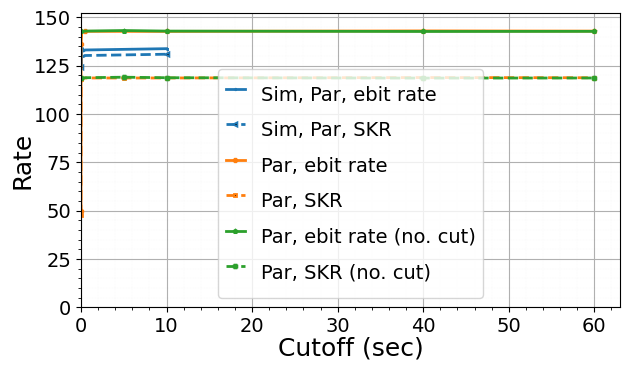

In [13]:
cut_off_list= [0.001,1000000.0,0.01,0.1,5.0,10.0,0.1,0.2,0.3,0.5,1.0,5.0,10.0,40.0,60.0]
each_scheme_cutoff_value = {}
selected_values = []
for cutoff in cut_off_list:
    print(cutoff)
    each_scheme_position_value = one_repeater_cutoff(100,cutoff)
    for scheme,pos_value in each_scheme_position_value.items():
        if "DT" not in scheme:
            for pos,value in pos_value.items():
                try:
                    each_scheme_cutoff_value[scheme][cutoff] = value
                except:
                    each_scheme_cutoff_value[scheme]={}
                    each_scheme_cutoff_value[scheme][cutoff] = value

                selected_values.append(value)
                    
scheme_cutoff_value,_ = get_no_cutoff_results(cut_off_list)
for scheme,pos_value in scheme_cutoff_value.items():
    if "DT" not in scheme:
        for pos,value in pos_value.items():
            try:
                each_scheme_cutoff_value[scheme][pos] = value
            except:
                each_scheme_cutoff_value[scheme]={}
                each_scheme_cutoff_value[scheme][pos] = value

            selected_values.append(value)
# each_scheme_cutoff_value,selected_values = get_no_cutoff_results(cut_off_list)
each_Le2e_t_cut_t_coh_all_skrs = {}
each_scheme_coh_all_skrs = {}
each_Le2e_each_coh_each_skr_cutoff = {}
each_L_explored_cutoffs = {}
each_L_explored_cohs = {}
cutoff_values  =set([])
each_scheme_cutoff_values = {}
each_coherence_time_cutoffs = {}
files = [
        # "../results/equal_distance_repeater_placement_coherence_cutoff_testing.csv",
        # "../results/equal_distance_repeater_placement_coherence_cutoff_testing_new_server.csv",
         "../results/equal_distance_repeater_placement_coherence_cutoff_testing_time_step_one.csv",
        ]
for file in files:
    with open(file, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            length =float(line[4])
            L = (float(line[14]))
            cut_off = float(line[4])/1000
            e2e_rate = float(line[7])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[26])
            R = int(line[3])
            coherence_time = float(line[27])
           
            # print()
            if  ( R in [1] and having_cut_off in ["True"]  and 
                 exp_class_com in ["True"]):

                if scheme =="parallel":
                    scheme_raw ="Sim, Par, ebit rate"
                    scheme_SKR ="Sim, Par, SKR"
                elif scheme =="sequential":
                    scheme_raw = "Sim, Seq, ebit rate"
                    scheme_SKR = "Sim, Seq, SKR"

                
                try:
                    each_scheme_cutoff_values[scheme_raw][cut_off/1000].append(e2e_rate)
                except:
                    try:
                        each_scheme_cutoff_values[scheme_raw][cut_off/1000]=[e2e_rate]
                    except:
                        each_scheme_cutoff_values[scheme_raw]={}
                        each_scheme_cutoff_values[scheme_raw][cut_off/1000]=[e2e_rate]
    
                try:
                    each_scheme_cutoff_values[scheme_SKR][cut_off/1000].append(skr)
                except:
                    try:
                        each_scheme_cutoff_values[scheme_SKR][cut_off/1000]=[skr]
                    except:
                        each_scheme_cutoff_values[scheme_SKR]={}
                        each_scheme_cutoff_values[scheme_SKR][cut_off/1000]=[skr]
           
            


for scheme,cutoff_values in each_scheme_cutoff_values.items():
    for cutoff,values in cutoff_values.items():
        
        avg_value = sum(values)/len(values)
        print(scheme,cutoff,avg_value)
        try:
            each_scheme_cutoff_value[scheme][cutoff] = avg_value
        except:
            each_scheme_cutoff_value[scheme]={}
            each_scheme_cutoff_value[scheme][cutoff]=avg_value
            
        selected_values.append(avg_value)


selected_scheme_keys = [
                 "Par, ebit rate (no. cut)",
                  "Par, SKR (no. cut)",
                        # "Seq, ebit rate (no. cut)",
                       
                       # "Seq, SKR (no. cut)",
                        "Sim, Par, ebit rate",
                        "Sim, Par, SKR",

                        "Sim, Seq, ebit rate",
                        "Sim, Seq, SKR",


                    "Par, ebit rate (no. cut)",
                    "Par, SKR (no. cut)"
    
                       ]

selected_scheme_keys=[
                        "Sim, Par, ebit rate",
                        "Sim, Par, SKR",
                        # "Sim, Seq, ebit rate",
                        # "Sim, Seq, SKR",
                        # "Seq, SKR",
                        # "Seq, ebit rate",
                         "Par, ebit rate",
                         "Par, SKR",
                        "Par, ebit rate (no. cut)",
                        "Par, SKR (no. cut)"
                       
]
# cut_off_list= [0.001,0.01,0.1,5,10,0.1,0.2,0.3,0.5,1,5,10,40,60]
cut_off_list= [0.001,0.01,0.1,0.2,0.3,0.5,5,10,40,60]
cut_off_list.sort()
print("each_scheme_cutoff_value",each_scheme_cutoff_value)
ploting_simple_y_as_x("Cutoff (sec)","Rate",
                        18, 18, 14,
                      14, 0, 0,
                      0,0,False,[],max(selected_values)+9,
                      
                      list(selected_scheme_keys),
                      each_scheme_cutoff_value,
                      cut_off_list,cut_off_list,
                      False,True,True,1,14,
                      "plots/repeater_chains_coherence_time_skr.pdf",True,2,6.4,3.8,False)

each_scheme_cutoff_value {'Seq, ebit rate': {0.001: 31.932773109243687, 1000000.0: 100.0, 0.01: 93.52772872591883, 0.1: 99.99999996472465, 5.0: 100.0, 10.0: 100.0, 0.2: 100.0, 0.3: 100.0, 0.5: 100.0, 1.0: 100.0, 40.0: 100.0, 60.0: 100.0}, 'Seq, SKR': {0.001: array([30.20909094]), 1000000.0: array([82.48245995]), 0.01: array([80.29846616]), 0.1: array([82.48246004]), 5.0: array([82.48245995]), 10.0: array([82.48245995]), 0.2: array([82.48245995]), 0.3: array([82.48245995]), 0.5: array([82.48245995]), 1.0: array([82.48245995]), 40.0: array([82.48245995]), 60.0: array([82.48245995])}, 'seq,e2e Fidelity': {0.001: 0.985356522805301, 1000000.0: 0.9475740317820847, 0.01: 0.9588028830869462, 0.1: 0.9475740320551174, 5.0: 0.9475740317820847, 10.0: 0.9475740317820847, 0.2: 0.9475740317820847, 0.3: 0.9475740317820847, 0.5: 0.9475740317820847, 1.0: 0.9475740317820847, 40.0: 0.9475740317820847, 60.0: 0.9475740317820847}, 'Par, ebit rate': {0.001: 49.832700224390074, 1000000.0: 142.86659756447452, 0

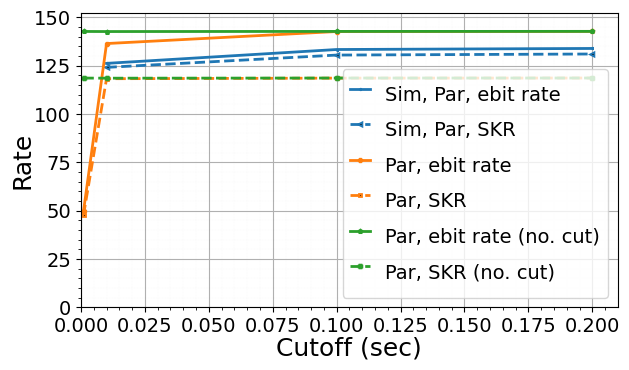

In [15]:
cut_off_list= [0.001,0.01,0.1,0.2]
cut_off_list.sort()
print("each_scheme_cutoff_value",each_scheme_cutoff_value)
ploting_simple_y_as_x("Cutoff (sec)","Rate",
                        18, 18, 14,
                      14, 0, 0,
                      0,0,False,[],max(selected_values)+9,
                      
                      list(selected_scheme_keys),
                      each_scheme_cutoff_value,
                      cut_off_list,cut_off_list,
                      False,True,True,1,14,
                      "plots/repeater_chains_coherence_time_skr.pdf",True,2,6.4,3.8,False)

In [ ]:
xticks_points = [0.1,0.3,0.5,0.7,0.9]
for Le2e in [200]:
    for cutoff in [50]:
        selected_values = []
        scheme_keys = []
        L_values = []
        avg_each_scheme_ratio_e2e_rate = {}
        each_scheme_point_value = one_repeater_cutoff(Le2e,cutoff/1000)
        for scheme,point_value in each_scheme_point_value.items():
            scheme  = scheme
            if scheme not in scheme_keys:
                scheme_keys.append(scheme)

            
            for point,value in point_value.items():
                if point not in L_values:
                    L_values.append(point)
                try:
                    avg_each_scheme_ratio_e2e_rate[scheme][point] = value
                except:
                        avg_each_scheme_ratio_e2e_rate[scheme]={}
                        avg_each_scheme_ratio_e2e_rate[scheme][point] = value

                
        print("done fore ",cutoff,Le2e)
        selected_scheme_keys = []
        for scheme in scheme_keys:
            if "ebit" in scheme or "SKR" in scheme or "DT" in scheme:
                if scheme not in selected_scheme_keys:
                    selected_scheme_keys.append(scheme)

        selected_values = []
        for scheme,key_value in avg_each_scheme_ratio_e2e_rate.items():
            if scheme in selected_scheme_keys:
                for point,value in key_value.items():
                    selected_values.append(value)
        ploting_simple_y_as_x("Repeater position","Rate",
                        18, 18, 14,
                      14, 0, 0,
                      0,0,True,xticks_points,max(selected_values)+1,
                      
                      list(selected_scheme_keys),
                      avg_each_scheme_ratio_e2e_rate,
                      L_values,L_values,
                      True,True,True,1,14,
                      "plots/repeater_chains_cutoff_rate_Le2e_"+str(Le2e)+"_cutoff_"+str(cutoff)+".pdf",True,2,6.4,3.8,False)

        

In [ ]:
ploting_simple_y_as_x("Repeater position","Rate",
                        18, 18, 14,
                      14, 0, 0,
                      0,0,True,xticks_points,max(selected_values)+1,
                      
                      list(selected_scheme_keys),
                      avg_each_scheme_ratio_e2e_rate,
                      L_values,L_values,
                      True,True,True,1,14,
                      "plots/repeater_chains_cutoff_rate_Le2e_"+str(Le2e)+"_cutoff_"+str(cutoff)+".pdf",True,2,6.4,3.8,False)

In [ ]:
def plot_color_map_sequential():
    # constants
    c = 2e5 # speed of light in fiber [km/s]
    p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware

    def T_sequential_no_cutoff(τ_coh, mu_link, F_link,links):
        """ Calculate performance metrics for asynchronous sequential scheme using analytical formulas
        inputs:
            τ_coh: coherence time of quantum memories
            mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
            entanglement swapping error
            F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
            links: list of segment (link) lengths in km
        outputs:
            Raw_rate: 1/ expected value of total time for e2e entanglement delivery
            *** application specific quantities:
            skr: secret key rate for qkd (does not include idle times of end memories)
            F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
        """
        if type(links) != np.ndarray:
            links = np.array(links)
        τs = links/c
        T_tot = 2* np.sum( τs / (p_link*Trans(links)) )
    
        raw_rate = 1/T_tot
        N_links = len(links) # number of links, i.e. no. of repeaters + 1
        mu_e2e = mu_link**(2*N_links-1)
        # secret key rate calculations
        f_memory_qkd = np.prod( p_link*Trans(links[1:])*np.exp(-4*τs[1:]/τ_coh)/(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
        f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
        ex = (1 - mu_e2e)/2
        ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
        skr = raw_rate * (1-h([ex])-h([ez]))
        #  fidelity of e2e Bell pairs
        Le2e = np.sum(links)
        τe2e = Le2e/c
        f_memory_bell = np.exp(-3*τe2e/τ_coh) *np.prod(p_link*Trans(links[1:])*np.exp(-4*τs[1:]/τ_coh)/(1- (1-p_link*Trans(links[1:]))*np.exp(-4*τs[1:]/τ_coh) ) )
        f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
        F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
    
        return raw_rate, skr, F_e2e



    def T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link,links):
        """ Calculate performance metrics for asynchronous sequential scheme using analytical formulas
        inputs:
            τ_cut: cut-off time
            τ_coh: coherence time of quantum memories
            mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
            entanglement swapping error
            F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
            links: list of segment (link) lengths in km
        outputs:
            Raw_rate: 1/ expected value of total time for e2e entanglement delivery
            *** application specific quantities:
            skr: secret key rate for qkd (does not include idle times of end memories)
            F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
        """
        if type(links) != np.ndarray:
            links = np.array(links)
        τs = links/c
        # implementing the recursion relation :
        ### Tn = Tn-1 / Pn + ( (1/Pn -1) τ_cut + Nm(ms[n],ps[n])*2*τs[n]/Pn)
        p1 = p_link*Trans(links[0])
        T_tot = 2*τs[0]/p1
        for i_l in np.arange(1,len(links)):
            L = links[i_l]
            m_n = int(τ_cut/(2*τs[i_l]))
            p_n = p_link*Trans(L)
            Nm = lambda x: (1-(1+m_n*x)*(1-x)**m_n)/x
            Pm = 1- (1-p_n)**m_n
            T_tot = T_tot / Pm +  (1/Pm -1)*τ_cut + Nm(p_n)*2*τs[i_l]/Pm
    
        raw_rate = 1/T_tot
        N_links = len(links) # number of links, i.e. no. of repeaters + 1
        mu_e2e = mu_link**(2*N_links-1)
        # secret key rate calculations
        m_arr = np.floor(τ_cut/(2*τs))
        Pm_arr = 1- (1-p_link*Trans(links))**m_arr
        f_memory_qkd = np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-2*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
        f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
        ex = (1 - mu_e2e)/2
        ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
        skr = raw_rate * (1-h([ex])-h([ez]))
        #  fidelity of e2e Bell pairs
        Le2e = np.sum(links)
        τe2e = Le2e/c
        f_memory_bell = np.exp(-3*τe2e/τ_coh) *np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-4*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-4*τs[1:]/τ_coh) )  )
        f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
        F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
    
        # skr, F_e2e = 0, 0
        return raw_rate, skr, F_e2e

    n = 4 # number of segments (i.e., no. of repeaters -1 )
    τ_coh_list = np.logspace(-4.3,-2,30) # coherence time [sec]
    print("τ_coh_list",τ_coh_list)
    F_link = 1 # fidelity of local BP
    mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)
    
    # Le2e_list = np.linspace(50,400,40)
    Le2e_list = np.linspace(200,200,1)
    print("Le2e_list",Le2e_list)
    each_scheme_coh_t_optimal_skr = {}
    num_τ = 20
    raw_rate_seq = np.zeros((len(Le2e_list),len(τ_coh_list),num_τ))
    skr_seq = np.zeros((len(Le2e_list),len(τ_coh_list),num_τ))
    Fe2e_seq = np.zeros((len(Le2e_list),len(τ_coh_list),num_τ))
    
    skr_seq_opt = np.zeros((len(Le2e_list),len(τ_coh_list)))
    raw_rate_seq_opt = np.zeros((len(Le2e_list),len(τ_coh_list)))
    Fe2e_seq_opt = np.zeros((len(Le2e_list),len(τ_coh_list)))
    τ_cut_opt =  np.zeros((len(Le2e_list),len(τ_coh_list)))
    skr_seq_no_cut =  np.zeros((len(Le2e_list),len(τ_coh_list)))
    coherene_values  = set([])
    for i_L, Le2e in enumerate(Le2e_list):
        Ls = [Le2e/n]*n
        τ_cut_list = np.logspace(-0.5,2,num_τ)*Ls[0]/c/2 # cutoff [sec]
        
        print(i_L, end='\r')
        for i_coh, τ_coh in enumerate(τ_coh_list):
            for i_t, τ_cut in enumerate(τ_cut_list):
                raw_rate_seq[i_L,i_coh,i_t], skr_seq[i_L,i_coh,i_t], Fe2e_seq[i_L,i_coh,i_t] = T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
                if isnan(skr_seq[i_L,i_coh,i_t]):
                    skr_seq[i_L,i_coh,i_t] = 1e-20
    
            idx = np.argmax(skr_seq[i_L,i_coh,:])
            optimal_skr = skr_seq[i_L,i_coh,idx]
            coherene_values.add(τ_coh)
            try:
                each_scheme_coh_t_optimal_skr["Seq"][τ_coh]=optimal_skr
            except:
                each_scheme_coh_t_optimal_skr["Seq"]={}
                each_scheme_coh_t_optimal_skr["Seq"][τ_coh]=optimal_skr
                
            # print(idx)
            # print(skr_seq[i_coh,:])
            skr_seq_opt[i_L,i_coh] = skr_seq[i_L,i_coh,idx]
            raw_rate_seq_opt[i_L,i_coh] = raw_rate_seq[i_L,i_coh,idx]
            Fe2e_seq_opt[i_L,i_coh] = Fe2e_seq[i_L,i_coh,idx]
            
            τ_cut_opt[i_L,i_coh] = τ_cut_list[idx]
            raw_rate_seq_no_cut, skr_seq_no_cut[i_L,i_coh], _ = T_sequential_no_cutoff(τ_coh, mu_link, F_link, Ls)










    
    from matplotlib import cm
    import matplotlib.cbook as cbook
    import matplotlib.colors as colors
    from matplotlib.ticker import LinearLocator
    
    # fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    # Make data.
    X, Y = np.meshgrid(τ_coh_list, Le2e_list)
    # Z = skr_seq_opt
    # # Plot the surface.
    # surf = ax.plot_surface(X, Y, skr_seq_no_cut, cmap=cm.coolwarm,
    #                        linewidth=0, antialiased=False)
    
    # ax.view_init(azim=0, elev=90)
    # plt.pcolor(X, Y, np.log(skr_seq_no_cut), cmap='viridis', vmin=1e-5, vmax=5)
    
    plt.figure(figsize=(4.2,3))
    
    Z = τ_cut_opt*1e3
    pcm = plt.pcolor(X, Y, Z,norm=colors.LogNorm(vmin=1e-2, vmax=5),
                       cmap='viridis', shading='auto')
    plt.colorbar(pcm, extend='max')
    # plt.colorbar()
    plt.ylabel("End-to-end distance [km]")
    plt.xlabel("coherence time [s]")
    plt.xscale("log")
    
    plt.figure(figsize=(4,3))
    Z = skr_seq_opt
    pcm = plt.pcolor(X, Y, Z,norm=colors.LogNorm(vmin=1e-5, vmax=150),
                       cmap='YlOrBr', shading='auto')
    plt.colorbar(pcm, extend='max')
    # plt.colorbar()
    plt.xscale("log")
    plt.ylabel("End-to-end distance [km]")
    plt.xlabel("coherence time [s]")
    plt.tight_layout()
    
    plt.figure(figsize=(4,3))
    Z = skr_seq_no_cut
    pcm = plt.pcolor(X, Y, Z,norm=colors.LogNorm(vmin=1e-5, vmax=150),
                       cmap='viridis', shading='auto')
    plt.colorbar(pcm, extend='max')
    # plt.colorbar()
    plt.xscale("log")
    plt.ylabel("End-to-end distance [km]")
    plt.xlabel("coherence time [s]")
    plt.tight_layout()
    return each_scheme_coh_t_optimal_skr,coherene_values,τ_cut_list
    # plt.figure()
    # plt.pcolor(X, Y, np.log(skr_seq_opt), cmap='viridis', vmin=-1e-5, vmax=5)
    # plt.colorbar()
    # plt.xscale("log")
    # plt.zscale("log")
    
each_scheme_coh_t_optimal_skr,coherene_values,τ_cut_list_sequential = plot_color_map_sequential()

In [ ]:
def plot_color_map_parallel():
    # constants
    c = 2e5 # speed of light in fiber [km/s]
    p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware
    each_Le2e_t_cut_t_coh_optimal_skr = {}
    Le2e_list = []
    def load_from_file():
        each_Le2e_t_cut_t_coh_all_skrs = {}
        each_Le2e_each_coh_each_skr_cutoff = {}
        each_L_explored_cutoffs = {}
        each_L_explored_cohs = {}
        with open("../results/equal_distance_repeater_placement_coherence_cutoff_distance_color_map_exp_time_step_10.csv", "r") as f:
            reader = csv.reader( (line.replace('\0','') for line in f) )
            for line in reader:
                scheme = line[0]
                exp_class_com = line[1]
                having_cut_off = line[2]
                R = int(line[3])
                length =float(line[4])
                L = (float(line[14]))
                try:
                    cut_off = float(line[4])/1000
                except:
                    cut_off = "False"
                e2e_rate = float(line[7])
                gen_delay = line[10]
                skr = float(line[11])
                avg_F = float(line[26])
                R = int(line[3])
                coherence_time = float(line[27])
                # print()
                if  ( R in [3] and having_cut_off in ["True"]  and 
                     exp_class_com in ["True"] and avg_F !=0.0 and scheme =="parallel"):
                    
                    try:
                        each_Le2e_t_cut_t_coh_all_skrs[L][coherence_time/1000].append(skr)
                    except:
                        try:
                            each_Le2e_t_cut_t_coh_all_skrs[L][coherence_time/1000]=[skr]
                        except:
                            each_Le2e_t_cut_t_coh_all_skrs[L]={}
                            each_Le2e_t_cut_t_coh_all_skrs[L][coherence_time/1000]=[skr]

                    try:
                        each_Le2e_each_coh_each_skr_cutoff[L][coherence_time/1000][skr] = cut_off/1000
                    except:
                        try:
                            each_Le2e_each_coh_each_skr_cutoff[L][coherence_time/1000]={}
                            each_Le2e_each_coh_each_skr_cutoff[L][coherence_time/1000][skr] = cut_off/1000
                        except:
                            each_Le2e_each_coh_each_skr_cutoff[L]={}
                            each_Le2e_each_coh_each_skr_cutoff[L][coherence_time/1000]={}
                            each_Le2e_each_coh_each_skr_cutoff[L][coherence_time/1000][skr] = cut_off/1000
                            
                    if L not in Le2e_list:
                        Le2e_list.append(L)
                    try:
                        each_L_explored_cutoffs[L].add(cut_off/1000)
                    except:
                        each_L_explored_cutoffs[L] = set([cut_off/1000])
                    try:
                        each_L_explored_cohs[L].add(coherence_time/1000)
                    except:
                        each_L_explored_cohs[L] = set([coherence_time/1000])
        for L,cutoffs in each_L_explored_cutoffs.items():
            print("for L %s cutoffs %s coherence %s  %s %s "%(L,len(list(cutoffs)),len(list(each_L_explored_cohs[L])),(list(cutoffs)),(list(each_L_explored_cohs[L]))))
        # for L,cutoffs in each_L_explored_cohs.items():
        #     print("for L %s coherences %s "%(L,len(list(cutoffs))))
        for L,coherecne_values in each_Le2e_t_cut_t_coh_all_skrs.items():
            for coherence_time,values in coherecne_values.items():
                optimal_skr = max(values)
                optimal_cutoff = each_Le2e_each_coh_each_skr_cutoff[L][coherence_time][optimal_skr]
                with open("each_L_each_coherence_optimal_cutoff_and_skr.csv", 'a') as newFile:                                
                    newFileWriter = csv.writer(newFile)
                    newFileWriter.writerow([L,coherence_time,optimal_cutoff,optimal_skr])
                each_Le2e_t_cut_t_coh_optimal_skr[L,coherence_time] = max(values)
        
    def get_optimal_cutoff(Le2e,τ_cut,τ_coh, mu_link, F_link, Ls):
        return each_Le2e_t_cut_t_coh_optimal_skr[Le2e][τ_coh]
    
    def T_parallel_no_cutoff(τ_coh, mu_link, F_link, links, cct= True, Nmax=10000):
        """ Runs Monte-Carlo iterations to calculate performance metrics for asynchronous parallel scheme
        inputs:
            τ_coh: coherence time of quantum memories
            mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
            entanglement swapping error
            F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
            links: list of segment (link) lengths in km
            cct: bool flag to turn on/off classical comm.
            Nmax: No. of MC iterations (if you see oscillations in secret key curves, you need to try larger numbers)
    
        outputs:
            Raw_rate: 1/ expected value of total time for e2e entanglement delivery
            *** application specific quantities:
            skr: secret key rate for qkd (does not include idle times of end memories)
            F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
        """
        Nmax = int(Nmax) # to make sure Nmax is an integer
        N_links = len(links) # number of links, i.e. no. of repeaters + 1
        if type(links) != np.ndarray:
            links = np.array(links)
        τs = links/c
        Ns = np.zeros((N_links,Nmax))
        Ns[0,:] = (2*F_geo(np.random.rand(Nmax),p_link*Trans(links[0]))-1)*τs[0]
        for i in range(1,N_links):
            Ns[i,:] = 2*F_geo(np.random.rand(Nmax),p_link*Trans(links[i]))*τs[i]
        
        Ts = np.zeros((N_links-1,Nmax))
        Ts[0,:] = np.abs(Ns[1,:]-Ns[0,:])+ 2*τs[1]
        for i in range(1,N_links-1):
            Ts[i,:] = np.abs(Ns[i+1,:]-Ns[i,:]+τs[i])+ 2*τs[i+1]
        f_memory_qkd = np.mean(np.exp(-np.sum(Ts,axis=0)/τ_coh))
        if cct: # inclduing classical comm. 
            Tsw = np.zeros((N_links-1,Nmax))
            Tsw[0,:] = np.max([Ns[1,:],Ns[0,:]],axis=0) + np.sum(τs[:1])
            for i in range(1,N_links-1):
                Tsw[i,:] = np.max([Ns[i+1,:],Ns[i,:]-τs[i]],axis=0)+ np.sum(τs[:(i+1)])
                
            T_tot = np.mean(np.max(Tsw,axis=0))           
            Ts_A = np.max(Tsw,axis=0)-Ns[0,:] + τs[0] 
            Ts_B = np.max(Tsw,axis=0)-Ns[-1,:] + τs[-1] 
            f_memory_bell = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))
        else:
            T_tot = np.mean(np.max(Ns,axis=0))
            Ts_A = np.max(Ns,axis=0)-Ns[0,:] + τs[0] 
            Ts_B = np.max(Ns,axis=0)-Ns[-1,:] + τs[-1] 
            f_memory_bell = np.mean(np.exp(-(np.sum(Ts,axis=0)+Ts_A+Ts_B)/τ_coh))
    
        raw_rate = 1/T_tot
        mu_e2e = mu_link**(2*N_links-1)
        # secret key rate calculations
        f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
        ex = (1 - mu_e2e)/2
        ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
        skr = raw_rate * (1-h([ex])-h([ez]))
        #  fidelity of e2e Bell pairs
        f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
        F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
        return raw_rate, skr, F_e2e


    load_from_file()
    
    n = 4 # number of segments (i.e., no. of repeaters -1 )
    τ_coh_list = np.logspace(-4.3,-2,30) # coherence time [sec]
    # coh_index=0
    # new_τ_coh_list = []
    # for item in τ_coh_list:
    #     if coh_index <4:
    #         new_τ_coh_list.append(item)
    #     coh_index+=1
    # τ_coh_list = new_τ_coh_list
    # τ_coh_list = np.array(τ_coh_list)
    print("τ_coh_list",τ_coh_list)
    F_link = 1 # fidelity of local BP
    mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)
    print("Le2e_list",(Le2e_list))
    Le2e_list = np.array(Le2e_list)
    
    num_τ = 200
    # num_τ = 4
    raw_rate_seq = np.zeros((len(Le2e_list),len(τ_coh_list),num_τ))
    skr_seq = np.zeros((len(Le2e_list),len(τ_coh_list),num_τ))
    Fe2e_seq = np.zeros((len(Le2e_list),len(τ_coh_list),num_τ))
    
    skr_seq_opt = np.zeros((len(Le2e_list),len(τ_coh_list)))
    raw_rate_seq_opt = np.zeros((len(Le2e_list),len(τ_coh_list)))
    Fe2e_seq_opt = np.zeros((len(Le2e_list),len(τ_coh_list)))
    τ_cut_opt =  np.zeros((len(Le2e_list),len(τ_coh_list)))
    skr_seq_no_cut =  np.zeros((len(Le2e_list),len(τ_coh_list)))
    
    for i_L, Le2e in enumerate(Le2e_list):
        Ls = [Le2e/n]*n
        τ_cut_list = np.logspace(-0.5,2,num_τ)*Ls[0]/c/2 # cutoff [sec]
        # coh_index=0
        # new_τ_cut_list = []
        # for item in τ_cut_list:
        #     if coh_index <4:
        #         new_τ_cut_list.append(item)
        #     coh_index+=1
        # print("new_τ_cut_list",new_τ_cut_list)
        # τ_cut_list = new_τ_cut_list
        # τ_cut_list= np.array(τ_cut_list)
        print(i_L, end='\r')
        for i_coh, τ_coh in enumerate(τ_coh_list):
            for i_t, τ_cut in enumerate(τ_cut_list):
                try:
                    raw_rate_seq[i_L,i_coh,i_t], skr_seq[i_L,i_coh,i_t], Fe2e_seq[i_L,i_coh,i_t] = get_optimal_cutoff(Le2e,τ_cut,τ_coh, mu_link, F_link, Ls)
                except:
                    if isnan(skr_seq[i_L,i_coh,i_t]):
                        skr_seq[i_L,i_coh,i_t] = 1e-20
    
            idx = np.argmax(skr_seq[i_L,i_coh,:])
            # print(idx)
            # print(skr_seq[i_coh,:])
            skr_seq_opt[i_L,i_coh] = skr_seq[i_L,i_coh,idx]
            raw_rate_seq_opt[i_L,i_coh] = raw_rate_seq[i_L,i_coh,idx]
            Fe2e_seq_opt[i_L,i_coh] = Fe2e_seq[i_L,i_coh,idx]
            
            τ_cut_opt[i_L,i_coh] = τ_cut_list[idx]
            raw_rate_seq_no_cut, skr_seq_no_cut[i_L,i_coh], _ = T_parallel_no_cutoff(τ_coh, mu_link, F_link, Ls)










    
    from matplotlib import cm
    import matplotlib.cbook as cbook
    import matplotlib.colors as colors
    from matplotlib.ticker import LinearLocator
    
    # fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    
    # Make data.
    X, Y = np.meshgrid(τ_coh_list, Le2e_list)
    # Z = skr_seq_opt
    # # Plot the surface.
    # surf = ax.plot_surface(X, Y, skr_seq_no_cut, cmap=cm.coolwarm,
    #                        linewidth=0, antialiased=False)
    
    # ax.view_init(azim=0, elev=90)
    # plt.pcolor(X, Y, np.log(skr_seq_no_cut), cmap='viridis', vmin=1e-5, vmax=5)
    
    plt.figure(figsize=(4.2,3))
    
    Z = τ_cut_opt*1e3
    pcm = plt.pcolor(X, Y, Z,norm=colors.LogNorm(vmin=1e-2, vmax=5),
                       cmap='viridis', shading='auto')
    plt.colorbar(pcm, extend='max')
    # plt.colorbar()
    plt.ylabel("End-to-end distance [km]")
    plt.xlabel("coherence time [s]")
    plt.xscale("log")
    
    plt.figure(figsize=(4,3))
    Z = skr_seq_opt
    pcm = plt.pcolor(X, Y, Z,norm=colors.LogNorm(vmin=1e-5, vmax=150),
                       cmap='YlOrBr', shading='auto')
    plt.colorbar(pcm, extend='max')
    # plt.colorbar()
    plt.xscale("log")
    plt.ylabel("End-to-end distance [km]")
    plt.xlabel("coherence time [s]")
    plt.tight_layout()
    
    plt.figure(figsize=(4,3))
    Z = skr_seq_no_cut
    pcm = plt.pcolor(X, Y, Z,norm=colors.LogNorm(vmin=1e-5, vmax=150),
                       cmap='viridis', shading='auto')
    plt.colorbar(pcm, extend='max')
    # plt.colorbar()
    plt.xscale("log")
    plt.ylabel("End-to-end distance [km]")
    plt.xlabel("coherence time [s]")
    plt.tight_layout()
    
    # plt.figure()
    # plt.pcolor(X, Y, np.log(skr_seq_opt), cmap='viridis', vmin=-1e-5, vmax=5)
    # plt.colorbar()
    # plt.xscale("log")
    # plt.zscale("log")
    
plot_color_map_parallel()
τ_cut_list = 20
τ_coh_list = 30


In [ ]:
print(each_scheme_coh_t_optimal_skr,coherene_values)
for item in τ_cut_list_sequential:
    print(item)

In [ ]:
each_Le2e_t_cut_t_coh_all_skrs = {}
each_scheme_coh_all_skrs = {}
each_Le2e_each_coh_each_skr_cutoff = {}
each_L_explored_cutoffs = {}
each_L_explored_cohs = {}
cutoff_values  =set([])
each_coherence_time_cutoffs = {}
with open("../results/equal_distance_repeater_placement_coherence_cutoff_distance_color_map_exp_time_step_10_new_server.csv", "r") as f:
    reader = csv.reader( (line.replace('\0','') for line in f) )
    for line in reader:
        scheme = line[0]
        exp_class_com = line[1]
        having_cut_off = line[2]
        R = int(line[3])
        length =float(line[4])
        L = (float(line[14]))
        
        cut_off = float(line[4])/1000
       
        e2e_rate = float(line[7])
        gen_delay = line[10]
        skr = float(line[11])
        avg_F = float(line[26])
        R = int(line[3])
        coherence_time = float(line[27])
        skr = e2e_rate
        # print()
        if  ( R in [3] and having_cut_off in ["True"]  and 
             exp_class_com in ["True"] and L==200.0):
            try:
                each_scheme_coh_all_skrs["Par"][coherence_time/1000].append(skr)
            except:
                try:
                    each_scheme_coh_all_skrs["Par"][coherence_time/1000]=[skr]
                except:
                    each_scheme_coh_all_skrs["Par"]={}
                    each_scheme_coh_all_skrs["Par"][coherence_time/1000]=[skr]
            try:
                each_coherence_time_cutoffs[coherence_time/1000].append(cut_off)
            except:
                each_coherence_time_cutoffs[coherence_time/1000]=[cut_off]
               
            
            cutoff_values.add(cut_off)


selected_values = []
for L,coh_skr_values in each_scheme_coh_all_skrs.items():
    for coh,skr_values in coh_skr_values.items():
        optimal_skr = max(skr_values)
        try:
            each_scheme_coh_t_optimal_skr["Par"][coh] = optimal_skr
        except:
            each_scheme_coh_t_optimal_skr["Par"]  ={}
            each_scheme_coh_t_optimal_skr["Par"][coh]=optimal_skr
        selected_values.append(optimal_skr)
coherene_values = list(coherene_values)
coherene_values.sort()
for coh,cutoffs in each_coherence_time_cutoffs.items():
    cutoffs.sort()
    print(coh,len(cutoffs),max(cutoffs))
selected_scheme_keys = ["Par","Seq"]

ploting_simple_y_as_x("Coherence time (sec)","Rate",
                        18, 18, 14,
                      14, 0, 0,
                      0,0,False,[],max(selected_values)+9,
                      
                      list(selected_scheme_keys),
                      each_scheme_coh_t_optimal_skr,
                      coherene_values,coherene_values,
                      False,True,True,1,14,
                      "plots/repeater_chains_coherence_time_skr.pdf",True,2,6.4,3.8,False)

In [ ]:
5.0118723362727245e-05 7 0.24343537998859455
6.016034869850822e-05 7 0.24343537998859455
7.221388161330746e-05 7 0.24343537998859455
8.668242140342028e-05 7 0.24343537998859455
0.0001499208614309617 7 0.24343537998859455
0.00010404983103657863 7 0.24343537998859455
0.00012489691869998188 7 0.24343537998859455
0.00017995852040347335 7 0.24343537998859455
0.0002592943797404667 7 0.24343537998859455
0.0003112457631423004 7 0.24343537998859455
0.00021601442758998932 6 0.17980623603595783
0.00037360595771877527 7 0.24343537998859455
0.0007756310250274166 7 0.24343537998859455
0.00044846043921615474 7 0.24343537998859455
0.0006461670787466969 7 0.24343537998859455
0.0005383125225570771 6 0.17980623603595783
0.001117572900082952 7 0.24343537998859455
0.000931033948916044 7 0.24343537998859455
0.0013414861922639134 7 0.24343537998859455
0.0016102620275609393 6 0.17980623603595783
0.0019328889200333672 7 0.24343537998859455
0.0023201562933498187 7 0.24343537998859455
0.0027850153052136296 6 0.17980623603595783
0.003343011965403283 6 0.17980623603595783
0.004012807031942776 6 0.17980623603595783
0.0048168000719874355 6 0.17980623603595783
0.00578187855753066 6 0.17980623603595783
0.00694031704750398 6 0.17980623603595783
0.01 6 0.17980623603595783
0.008330856527094902 6 0.17980623603595783

In [ ]:
τ_coh_list = np.linspace(0.1,0.1,1)
print(τ_coh_list)

In [ ]:
τ_coh_list = np.logspace(-4.3,-2,30)
τ_coh_list
c = 2e5
τ_cut_list = np.logspace(-0.5,2,20)*50/c/2 # cutoff [sec]
for ct in τ_cut_list:
    print((ct))
print("--")
for coh,cutoff_values in each_coherence_time_cutoffs.items():
    print((max(cutoff_values)))
print("coherence_values",len(coherence_values),coherence_values)

In [ ]:
L0_list = np.linspace(10,800,101)
selected_values = []
each_scheme_L_values ={}
for i, L0 in enumerate(L0_list):
    raw_rate,SKR = get_secret_key_rate("equal",0.05,0.1,L0,5)
    try:
        each_scheme_L_values["seq,raw rate"][L0] =  raw_rate
    except:
        each_scheme_L_values["seq,raw rate"] ={}
        each_scheme_L_values["seq,raw rate"][L0] =  raw_rate
    try:
        each_scheme_L_values["seq,skr"][L0] =  SKR
    except:
        each_scheme_L_values["seq,skr"] ={}
        each_scheme_L_values["seq,skr"][L0] =  SKR
    selected_values.append(raw_rate)
    selected_values.append(SKR)
    
with open("../results/equal_distance_repeater_placement_as_distance.csv", "r") as f:
    reader = csv.reader( (line.replace('\0','') for line in f) )
    for line in reader:
        scheme = line[0]
        exp_class_com = line[1]
        having_cut_off = line[2]
        R = int(line[3])
        length =float(line[4])
        L = (float(line[14]))
        try:
            cut_off = float(line[4])/1000
        except:
            cut_off = "False"
        e2e_rate = float(line[7])
        gen_delay = line[10]
        skr = float(line[11])
        avg_F = float(line[26])
        R = int(line[3])
        coherence_time = float(line[27])
        if  ( R in [5] and having_cut_off in ["True"]  and 
             exp_class_com in ["True"] and avg_F !=0.0 and scheme =="parallel"):
            # print("passed")
            try:
                each_scheme_L_values["par,raw rate"][L] =  e2e_rate
            except:
                each_scheme_L_values["par,raw rate"] ={}
                each_scheme_L_values["par,raw rate"][L] =  e2e_rate
            try:
                each_scheme_L_values["par,skr"][L] =  skr
            except:
                each_scheme_L_values["par,skr"] ={}
                each_scheme_L_values["par,skr"][L] =  skr
        selected_values.append(e2e_rate)
        selected_values.append(skr)

selected_scheme_keys = ["par,skr","par,raw rate","seq,skr","seq,raw rate"]
ploting_simple_y_as_x("L (km)","rate",
                        18, 18, 14,
                      14, 0, 0,
                      0,0,False,[],max(selected_values),
                      list(selected_scheme_keys),
                      each_scheme_L_values,
                      L0_list,L0_list,
                      True,True,True,1,12,
                      "plots/repeater_chains_rate_as_L.pdf",True,2,6.4,3.8,False)

In [ ]:
x= []
y = []
for i in range(1000000):
    raw_rate,SKR = get_secret_key_rate("not",0.05,0.1,200,5)
    x.append(raw_rate)
    y.append(SKR)
print(len(x))
x= np.array(x)
y= np.array(y)
x_axis_tick_font_size =16
y_axis_tick_font_size = 18
legend_font_size = 16
# hist(x,y,x_axis_tick_font_size,y_axis_tick_font_size,legend_font_size, 40, "raw","plots/histogram_sequential.pdf")

In [ ]:
x2 = []
y2 = []
with open("../results/random_placement_exp_time_step_5.csv", "r") as f:
    reader = csv.reader( (line.replace('\0','') for line in f) )
    for line in reader:
        scheme = line[0]
        exp_class_com = line[1]
        having_cut_off = line[2]
        R = int(line[3])
        length =float(line[4])
        L = (float(line[14]))
        try:
            cut_off = float(line[4])/1000
        except:
            cut_off = "False"
        e2e_rate = float(line[7])
        gen_delay = line[10]
        skr = float(line[11])
        avg_F = float(line[26])
        R = int(line[3])
        if  ( R in [5] and having_cut_off in ["True"]  and 
             exp_class_com in ["True"] and avg_F !=0.0 and L in [200]):
            x2.append(e2e_rate)
            y2.append(skr)

x2= np.array(x2)
y2= np.array(y2)
print(len(x2))
x_axis_tick_font_size =18
y_axis_tick_font_size = 18
legend_font_size = 16


In [ ]:
hist(x,y,x2,y2,x_axis_tick_font_size,y_axis_tick_font_size,legend_font_size, 40, "raw","plots/histogram_parallel.pdf")

In [ ]:



result_file_path = "../results/equal_distance_repeater_placement_cutoff_coherence_exp_time_step_5v2.csv"

        

counter = 0
repeater_lengths = [6,7,8,9,10]

    
M_values = [1000]
D_values= [100,200,50,10]
R_values = [2,5,10,20]
num_of_user_pairs_values = [1]

unique_run_numbers = set([])
each_repeater_chain_length_rate_required_W = {}
selected_genetic_alg_steps = []
rl_algorithm_epochs = []
repeater_placement_values = []
scheme_keys = []
egr_values2 = []
tested_work_loads = []
selected_epochs_for_genetic = []
checked_topologies = []
min_rate_values = []
W_values = []
Metro_Area_link_lenght_values = []
processing_time_values = []
each_scheme_memory_utility = {}
L_values = []
end_nodes_life_time_values = []
repeaters_life_time_values = []

with open(result_file_path, "r") as f:
    reader = csv.reader( (line.replace('\0','') for line in f) )
    for line in reader:
        scheme = line[0]
        exp_class_com = line[1]
        having_cut_off = line[2]
        R = int(line[3])
        length =float(line[4])
        L = (float(line[14]))
        try:
            cut_off = float(line[4])/1000
        except:
            cut_off = "False"
        e2e_rate = float(line[7])
        gen_delay = line[10]
        skr = float(line[11])
        avg_F = float(line[26])
        R = int(line[3])
        coherence_time = float(line[27])
        if  ( R in [5] and having_cut_off in ["True"]  and 
             exp_class_com in ["True"] and avg_F !=0.0 and L in [400]):

            if scheme =="parallel":
                scheme ="sim,par"
            elif scheme =="sequential":
                scheme = "sim,seq"
            try:
                each_scheme_memory_utility[coherence_time,cut_off].append(skr)
            except:
                each_scheme_memory_utility[coherence_time,cut_off] = [skr]
                    
            if coherence_time not in repeaters_life_time_values:
                repeaters_life_time_values.append(coherence_time)
            if cut_off not in end_nodes_life_time_values:
                end_nodes_life_time_values.append(cut_off)

X = []
Y =[]
Z = []
rate_or_utility_values = []
repeaters_life_time_values.sort()
end_nodes_life_time_values.sort()
print("repeaters_life_time_values ",repeaters_life_time_values)
print("end_nodes_life_time_values",end_nodes_life_time_values)

for end_node_LT in end_nodes_life_time_values:
    for rep_LT in repeaters_life_time_values:
        if (rep_LT,end_node_LT) in each_scheme_memory_utility:
            utilities = each_scheme_memory_utility[rep_LT,end_node_LT]
            avg_utility = sum(utilities)/len(utilities)
            X.append(end_node_LT)
            Y.append(rep_LT)
            Z.append(avg_utility)

print("Z ",min(Z),sum(Z)/len(Z),max(Z))
plotting_2D("cutoff (ms)","coherence time (ms)","SKR",
                          10, 10, 10,
                          10, 0, 0,
                          0,0,
                          500,
                          X,Y,Z,0,6,14,
                          False,True,
                          False,1,
                          18,"plots/2D_memory_cutoff_coherence_time_parallel.pdf",
                          False,3,6,3.6)

In [ ]:
print(min(Z),median(Z),max(Z))

In [ ]:

X = []
Y =[]
Z = []
for cutoff in range(10,500,5):
    for coherecne_time in range(10,500,10):
        skr = get_secret_key_rate(cutoff/1000,coherecne_time/1000,400,5)
        X.append(cutoff)
        Y.append(coherecne_time)
        Z.append(skr)
        print("done fore cutoff %s for coherence %s SKR %s "%(cutoff,coherecne_time,skr))
plotting_2D("cutoff (ms)","coherence time (ms)","SKR",
                          10, 10, 10,
                          10, 0, 0,
                          0,0,
                          500,
                          X,Y,Z,0,5,7,
                          False,True,
                          False,1,
                          18,"plots/2D_memory_cutoff_coherence_time.pdf",
                          False,3,6,3.6)



In [ ]:
print(min(Z),median(Z),max(Z))
L0_list = np.linspace(10,800,101)
print(L0_list,len(L0_list))

In [ ]:
plot_histogram(x,"instances","Occurance","","plots/histogram.pdf")

In [ ]:
# # import numpy as np
# # import matplotlib.pyplot as plt

# # x = [0,5,9,10,15]
# # y = [0,1,2,3,4]
# # plt.plot(x,y)
# # plt.xticks(np.arange(min(x), max(x)+1, 0.2))
# # plt.show()
# import numpy
# import matplotlib.pyplot as plt

# #import globalsvariables
# import glob
# import os
# import datetime
# import calendar
# import glob, os
# import itertools
# from collections import OrderedDict
# import sys
# import csv
# import numpy as np

# from collections import OrderedDict
# import numpy
# colors = ['BLACK', 'RED', 'MAROON', 'YELLOW','OLIVE','LIME','GREEN','AQUA','TEAL']

# import numpy as np
# from pylab import *
# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
# import glob
# import os
# import datetime
# import calendar
# import glob, os
# import itertools
# from collections import OrderedDict
# import numpy as np


# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
# import glob
# import os
# import datetime

# import calendar
# import glob, os
# import itertools
# from collections import OrderedDict

# import numpy as np
# import numpy
# import matplotlib.pyplot as plt
# import numpy as np
# import numpy as np
# from pylab import *
# import numpy as np

# from mpl_toolkits.mplot3d import axes3d
# import matplotlib.pyplot as plt


# from collections import OrderedDict
# import numpy
# colors = ['BLACK', 'RED', 'MAROON', 'YELLOW','OLIVE','AQUA','LIME','GREEN','TEAL']
# markers=['3','4','8','s','p','P','o','v','^','<','*','h','H','+','x','X','D','d','|','_']
# import numpy as np

# global_font_size = 32
# figure_width = 10
# figure_highth = 10

# space_from_x_y_axis = 25
# style=itertools.cycle(["-","--","-.",":","None",""," ","-","--","-.",":"])




# markers=['4','<','8','s','p','P','o','v','^','<','*','h','H','+','x','X','D','d','|','_']
# descriptions=['point', 'pixel', 'circle', 'triangle_down', 'tri_down', 'octagon', 'square', 'pentagon', 'plus (filled)','star', 'hexagon1', 'hexagon2', 'plus', 'x', 'x (filled)','diamond', 'thin_diamond', 'vline', 'hline']
# csfont = {'fontname':'Times New Roman'}
# # import statistics
# from pylab import *
# # import pandas
# import pandas as pd


# def set_plotting_global_attributes(x_axis_label,y_axis_label,x_axis_font_size,
#                                    y_axis_font_size,x_axis_tick_font_size,
#                                    y_axis_tick_font_size,x_axis_pad,y_axis_pad,
#                                   image_width,image_lenght):
#     import matplotlib.pyplot as plt
#     global global_font_size
#     global figure_width
#     global figure_highth
#     global space_from_x_y_axis
#     global style
#     global markers
#     global csfont
#     global descriptions
#     font_size = 44
# #     plt.figure(figsize=(10,0))
#     global fig
#     global global_mark_every
#     global_mark_every = 1
#     #matplotlib.rcParams['text.usetex'] = True
#     fig = plt.figure()
#     if image_width==0:
#         image_width = 5.6
#         image_lenght = 3.8
#     fig.set_size_inches(image_width, image_lenght, forward=True)# default 
# #     fig.set_size_inches(14, 8)
# #     fig.set_size_inches(8, 6)
#     global style
#     #matplotlib.rcParams['text.usetex'] = True
#     global markers
    
#     global descriptions

#     label_size = 40
#     #matplotlib.rcParams['text.usetex'] = True
#     csfont = {'fontname':'Times New Roman'}
#     #write your code related to basemap here
#     #plt.title('title',**csfont)
#     plt.rcParams['xtick.labelsize'] = x_axis_tick_font_size 
#     #matplotlib.rcParams['text.usetex'] = True
#     plt.rcParams['ytick.labelsize']= y_axis_tick_font_size
#     #matplotlib.rcParams['text.usetex'] = True
#     plt.xlabel(x_axis_label, fontsize=x_axis_font_size,labelpad=x_axis_pad)
#     #matplotlib.rcParams['text.usetex'] = True
#     plt.ylabel(y_axis_label,fontsize=y_axis_font_size,labelpad=y_axis_pad)
    
#     plt.grid(True)
#     plt.tight_layout()
#     #matplotlib.rcParams['text.usetex'] = True
#     #plt.ylim(ymin=0) 
#     return plt
# def ploting_simple_y_as_x(x_axix_label,y_axix_label,
#                           x_axis_font_size, y_axis_font_size, x_axis_tick_font_size,
#                           y_axis_tick_font_size, x_axis_pad, y_axis_pad,
#                           x_min_value,y_axis_provided_min_value,
#                           y_axis_provided_max_value,
#                           dictionary_keys_in_order,
#                           each_scheme_each_step_value,
#                           x_axis_points,tickets_on_x_axis,
#                           log_scale,legend_flag,
#                           print_flag,legend_num_column,
#                           legend_font_size,plot_name,
#                           having_mark_on_linkes_flag,given_marker_size,image_width,plot_height,
#                          legends_on_the_right_flag):
    
 
#     colors = ['BLACK', 'RED', 'BLUE','GREEN','MAROON','AQUA','OLIVE','LIME','TEAL']
#     style=[ 'solid', 'dashed', 'dashdot', 'dotted',":",'solid', 'dashed', 'dashdot']
#     plt = set_plotting_global_attributes(x_axix_label,y_axix_label,x_axis_font_size, 
#                           y_axis_font_size, x_axis_tick_font_size,
#                           y_axis_tick_font_size, x_axis_pad, y_axis_pad,
#                                          image_width,plot_height)
                        
            
#     #print Read_and_Detection_time_with_convergence_Det_Alg
#     my_dic = {}


#     my_class_labels = []

    
# #     x = np.arange(len(topologies))
#     x = np.arange(max(x_axis_points))
#     x = []
#     for point_x_axis in x_axis_points:
#         x.append((point_x_axis))
#     x.sort()
#     #print('we have %s as our x '%(x))
#     sizes = []
#     #plt.gca().set_color_cycle(['BLACK', 'RED', 'MAROON', 'YELLOW','OLIVE','LIME','GREEN','AQUA','TEAL'])

#     #print 'Convergene_time_dictionary',Convergene_time_dictionary
#     index = 0
#     color_index =0
#     for scheme_key in dictionary_keys_in_order:
#         label_of_result = scheme_key
#         y_axis_values = []
#         import math
#         from math import log
#         x_values_for_this_scheme = []
#         for point in x_axis_points:
#             try:
#                 value  = each_scheme_each_step_value[scheme_key][point]
#                 if print_flag:
#                     print("we get the values for scheme %s point %s %s"%(scheme_key,point,value))            
#                 y_axis_values.append(value)
#                 x_values_for_this_scheme.append(point)
#             except:
#                 pass
#         sizes.append(str(scheme_key))
#         #print("these are the x and y axis values",Convergence_times,label_of_result)
#         if having_mark_on_linkes_flag:
#             plot(x_values_for_this_scheme, y_axis_values,colors[color_index],
#                  linestyle=style[index],marker=markers[index],markevery=(0.0,0.1),linewidth=3.0,
#                  markersize=given_marker_size,markerfacecolor='black',markeredgewidth='2', 
#                  markeredgecolor=colors[color_index])
#         else:
#             plot(x_values_for_this_scheme, y_axis_values,colors[color_index],
#                  linestyle=style[index],markevery=(0.0,0.1),linewidth=3.0)
            
# #         print("scheme %s x points %s      "%(scheme_key,x))
# #         print("scheme %s y_axis points %s "%(scheme_key,y_axis_values))
#         index = index +1
#         color_index+=1
#         if color_index >=len(colors):
#             color_index = 1
#         if index >= len(style):
#             index = 2
#     my_class_labels = sizes

#     plt.grid(True)
#     plt.xlim(xmin=x_min_value)

#     plt.grid(True)

#     plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')

#     plt.tight_layout()
#     if log_scale:
#         plt.yscale('log')
#     if legend_flag:
#         plt.legend([label for label in my_class_labels ],fontsize=legend_font_size, ncol=legend_num_column,handleheight=2.4, labelspacing=0.02)
#     if legends_on_the_right_flag:
#         ax = plt.subplot(111)
#         ax.legend([label for label in my_class_labels ],fontsize=legend_font_size,loc='center left', bbox_to_anchor=(1, 0.5))
#         # ax.xticks(np.arange(min(x_values_for_this_scheme), max(x_values_for_this_scheme)+1, 0.1))
#     plt.ylim(y_axis_provided_min_value, y_axis_provided_max_value)
#     plt.minorticks_on()
#     plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
#     ax = plt.subplot(111)
#     # start, end = ax.get_xlim()
#     # ax.xaxis.set_ticks(np.arange(start, end, 0.1))
#     plt.xticks(np.arange(0, 1, 20)) 
#     plt.grid( which='minor', color='#999999', linestyle='-', alpha=0.1)
#     plt.xticks(np.arange(min(x_values_for_this_scheme), max(x_values_for_this_scheme)+1, 0.3))
#     plt.tight_layout()
#     plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')
#     # plt.locator_params(axis='both', nbins=10)
#     plt.savefig(plot_name)
#     plt.show()
# avg_each_scheme_ratio_e2e_rate = {
#     "one":{0:1,1:2,2:3,3:4,4:5,5:7},
#     "two":{0:2,1:4,2:5,3:6,4:7,5:9}
# }
# ploting_simple_y_as_x("Repeater position","Ebit rate",
#                         12, 12, 12,
#                       12, 0, 0,
#                       0,0,max([10]),
                      
#                       list(["one","two"]),
#                       avg_each_scheme_ratio_e2e_rate,
#                       [0,1,2,3,4,5],[0,1,2,3,4,5],
#                       True,True,True,1,12,
#                       "plots/repeater_chains_cutoff_rate_Le2e_test.pdf",True,2,6.4,3.8,False)


In [ ]:
import pdb
pdb.set_trace()
selected_scheme_keys= [
    
                    # "L=250,cut10,sequential,raw rate",
                    #   "L=250,cut10,parallel,raw rate",
                      "L=250,cut20,sequential,raw rate",
                      "L=250,cut20,parallel,raw rate",
                      # "L=250,cut50,sequential,raw rate",
                      # "L=250,cut50,parallel,raw rate"


                    # "L=250,cut10,sequential,raw rate",
                    #   "L=250,cut10,parallel,raw rate",
                    #   "L=250,cut20,sequential,raw rate",
                    #   "L=250,cut20,parallel,raw rate",
                      # "L=250,cut50,sequential,raw rate",
                      # "L=250,cut50,parallel,raw rate"
    
                      ]
ploting_simple_y_as_x("Repeater position","Ebit rate",
                18, 18, 14,
              14, 0, 0,
              0,0,max([0.3]),
              
              list(selected_scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              False,True,True,1,12,
              "plots/repeater_chains_cutoff_rate.pdf",True,2,6.4,3.8,False)

In [ ]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware


def T_sequential_cutoff2(τ_cut,τ_coh, mu_link, F_link,links):
    """ Calculate performance metrics for asynchronous sequential scheme using analytical formulas
    inputs:
        τ_cut: cut-off time
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        links: list of segment (link) lengths in km
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    if type(links) != np.ndarray:
        links = np.array(links)
    τs = links/c
    # implementing the recursion relation :
    ### Tn = Tn-1 / Pn + ( (1/Pn -1) τ_cut + Nm(ms[n],ps[n])*2*τs[n]/Pn)
    p1 = p_link*Trans(links[0])
    T_tot = 2*τs[0]/p1
    for i_l in np.arange(1,len(links)):
        L = links[i_l]
        m_n = int(τ_cut/(2*τs[i_l]))
        p_n = p_link*Trans(L)
        Nm = lambda x: (1-(1+m_n*x)*(1-x)**m_n)/x
        Pm = 1- (1-p_n)**m_n
        T_tot = T_tot / Pm +  (1/Pm -1)*τ_cut + Nm(p_n)*2*τs[i_l]/Pm

    raw_rate = 1/T_tot
    N_links = len(links) # number of links, i.e. no. of repeaters + 1
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    m_arr = np.floor(τ_cut/(2*τs))
    Pm_arr = 1- (1-p_link*Trans(links))**m_arr
    f_memory_qkd = np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-2*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    print("f_e2e_qkd",f_e2e_qkd)
    f_e2e_qkd = 0.6095738302575425
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    raw_rate = 1.6519930671093899

    # analytical,seq,raw rate,n=3 point 150.0 1.6519930671093899
    # analytical,seq,F,n=3 point 150.0 0.6095738302575425
    # analytical,seq,skr,n=3 point 150.0 0.05769747652734004
    
    skr = raw_rate * (1-h([ex])-h([ez]))
    print("skr is ",skr)
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    Le2e = np.sum(links)
    τe2e = Le2e/c
    f_memory_bell = np.exp(-3*τe2e/τ_coh) *np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-4*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-4*τs[1:]/τ_coh) )  )
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4

    # skr, F_e2e = 0, 0
    return raw_rate, skr, F_e2e
F_link = 1 # fidelity of local BP
mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)

Ls = [400/(3+1)]*(3+1)
τ_coh = 0.1 # coherence time [sec]
τ_cut = 150/1000
raw_rate_seq, skr_seq, Fe2e_seq = T_sequential_cutoff2(τ_cut,τ_coh, mu_link, F_link, Ls)
# print("raw_rate_seq, skr_seq, Fe2e_seq ",raw_rate_seq, skr_seq, Fe2e_seq )
skr_seq = skr_seq[0]


In [ ]:
avg_e2e_f = 0.6095738302575425
def h2(e_x):
    return -e_x*math.log2(e_x)-(1-e_x)*math.log2(1-e_x)
mu_e2e=(self.mu**n)*np.prod(self.mu_i[self.path_id])

e_x =(1+mu_e2e)/2-(mu_e2e*avg_e2e_f)
e_z=(1-mu_e2e)/2
r= 1-self.h2(e_x)-self.h2(e_z)
S = rate*r
print(S)

In [ ]:
# analytical,seq,raw rate,n=3 point 150.0 1.6519930671093899
# analytical,seq,F,n=3 point 150.0 0.5350374529022418

In [ ]:
# constants
c = 2e5 # speed of light in fiber [km/s]
p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware


def T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link,links):
    """ Calculate performance metrics for asynchronous sequential scheme using analytical formulas
    inputs:
        τ_cut: cut-off time
        τ_coh: coherence time of quantum memories
        mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
        entanglement swapping error
        F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        links: list of segment (link) lengths in km
    outputs:
        Raw_rate: 1/ expected value of total time for e2e entanglement delivery
        *** application specific quantities:
        skr: secret key rate for qkd (does not include idle times of end memories)
        F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
    """
    if type(links) != np.ndarray:
        links = np.array(links)
    τs = links/c
    # implementing the recursion relation :
    ### Tn = Tn-1 / Pn + ( (1/Pn -1) τ_cut + Nm(ms[n],ps[n])*2*τs[n]/Pn)
    p1 = p_link*Trans(links[0])
    T_tot = 2*τs[0]/p1
    for i_l in np.arange(1,len(links)):
        L = links[i_l]
        m_n = int(τ_cut/(2*τs[i_l]))
        p_n = p_link*Trans(L)
        Nm = lambda x: (1-(1+m_n*x)*(1-x)**m_n)/x
        Pm = 1- (1-p_n)**m_n
        T_tot = T_tot / Pm +  (1/Pm -1)*τ_cut + Nm(p_n)*2*τs[i_l]/Pm

    raw_rate = 1/T_tot
    N_links = len(links) # number of links, i.e. no. of repeaters + 1
    mu_e2e = mu_link**(2*N_links-1)
    # secret key rate calculations
    m_arr = np.floor(τ_cut/(2*τs))
    Pm_arr = 1- (1-p_link*Trans(links))**m_arr
    f_memory_qkd = np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-2*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-2*τs[1:]/τ_coh) )  )
    f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
    ex = (1 - mu_e2e)/2
    ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
    skr = raw_rate * (1-h([ex])-h([ez]))
    #  fidelity of e2e Bell pairs
    Le2e = np.sum(links)
    τe2e = Le2e/c
    f_memory_bell = np.exp(-3*τe2e/τ_coh) *np.prod( p_link*Trans(links[1:])/Pm_arr[1:] * np.exp(-4*τs[1:]/τ_coh) * (1- (1-p_link*Trans(links[1:]))**m_arr[1:] *np.exp(-4*m_arr[1:]*τs[1:]/τ_coh) )  /(1- (1-p_link*Trans(links[1:]))*np.exp(-4*τs[1:]/τ_coh) )  )
    f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
    F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4

    # skr, F_e2e = 0, 0
    return raw_rate, skr,F_e2e# f_e2e_qkd

In [ ]:
def get_analytical_results_with_cut_off(R,Le2e,τ_cut):
    F_link = 1 # fidelity of local BP
    mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)

    n = 3 # number of segments (i.e., no. of repeaters -1 )
    Ls = [Le2e/(R+1)]*(R+1)
    τ_coh = 0.1 # coherence time [sec]
    raw_rate_seq, skr_seq, Fe2e_seq = T_sequential_cutoff(τ_cut,τ_coh, mu_link, F_link, Ls)
    # print("raw_rate_seq, skr_seq, Fe2e_seq ",raw_rate_seq, skr_seq, Fe2e_seq )
    skr_seq = skr_seq[0]
    each_scheme_cutoff_result = {}
    
    try:
        each_scheme_cutoff_result["analytical,seq,raw rate,n="+str(R)][τ_cut*1000] = raw_rate_seq
    except:
            each_scheme_cutoff_result["analytical,seq,raw rate,n="+str(R)]={}
            each_scheme_cutoff_result["analytical,seq,raw rate,n="+str(R)][τ_cut*1000] = raw_rate_seq
    try:
        each_scheme_cutoff_result["analytical,seq,skr,n="+str(R)][τ_cut*1000] = skr_seq
    except:
        each_scheme_cutoff_result["analytical,seq,skr,n="+str(R)]={}
        each_scheme_cutoff_result["analytical,seq,skr,n="+str(R)][τ_cut*1000] = skr_seq
    try:
        each_scheme_cutoff_result["analytical,seq,F,n="+str(R)][τ_cut*1000] = Fe2e_seq
    except:
        each_scheme_cutoff_result["analytical,seq,F,n="+str(R)] ={}
        each_scheme_cutoff_result["analytical,seq,F,n="+str(R)][τ_cut*1000] = Fe2e_seq
    return each_scheme_cutoff_result

In [ ]:
def sequential_parallel_for_one_repeater(R,cut_off):
    c = 2e5 # speed of light in fiber [km/s]
    p_link = 1.0 # photon insertion loss incorporates various efficiencies of the experimental hardware
    def T_parallel_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link, Nmax=100000):
        """ calculates the performance of parallel scheme with one repeater
        inputs:
            L1,L2: elementary link lengths *** works for arbitrary L1,L2 ****
            τ_cut: cut-off time
            τ_coh: coherence time of quantum memories
            mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
            entanglement swapping error
            F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
            Nmax: ensemble size for averaging
        outputs:
            Raw_rate: 1/ expected value of total time for e2e entanglement delivery
            *** application specific quantities:
            skr: secret key rate for qkd (does not include idle times of end memories)
            F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
        """
        Nmax = int(Nmax) # to make sure Nmax is an integer
        τ1 = L1/c
        τ2 = L2/c
        p1 = p_link*Trans(L1)
        p2 = p_link*Trans(L2)
        # N1 = F_geo(np.random.uniform(low=p1, high=1, size=(Nmax,)),p1)
        # N2 = F_geo(np.random.uniform(low=p2, high=1, size=(Nmax,)),p2)
        N1 = F_geo(np.random.rand(Nmax),p1)
        N2 = F_geo(np.random.rand(Nmax),p2)
        Ts = np.max(np.array([(2*N1-1)*τ1,2*N2*τ2]),axis=0) # swap moment
        t1L = Ts-(2*N1-1)*τ1 # elapsed time of leftside repeater's memory 
        t1R = Ts-2*(N2-1)*τ2 # elapsed time of rightside repeater's memory 
        indsL = np.argwhere( t1L <= τ_cut )[:,0]
        indsR = np.argwhere( t1R <= τ_cut )[:,0]
        succ_inds = np.intersect1d(indsL,indsR)
        T_succ = np.sum(Ts[succ_inds]+ τ1) 
        fail_inds = list(set(list(range(Nmax)))-set(succ_inds))
        # L_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 <= 2*N2[fail_inds]*τ2 ).shape[0]
        # R_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 > 2*N2[fail_inds]*τ2 ).shape[0]
        # T_fail = (2*τ1/p1 + τ_cut)*L_runs + (2*τ2*(1/p2-1)+τ1 + τ_cut)*R_runs
        # T_fail = (2*τ1/p1 + τ_cut)*(Nmax-len(succ_inds))
        L_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 <= 2*N2[fail_inds]*τ2 )[:,0]
        R_runs = np.argwhere( (2*N1[fail_inds]-1)*τ1 > 2*N2[fail_inds]*τ2 )[:,0]
        # print(list(np.array(fail_inds)[L_runs]))
        left_mem_on_idx = list(np.array(fail_inds)[L_runs])
        right_mem_on_idx = list(np.array(fail_inds)[R_runs])
        T_elapsed_left = 2*N1[left_mem_on_idx]*τ1 + τ_cut
        T_elapsed_right = 2*(N2[right_mem_on_idx]-1)*τ2 +τ1+ τ_cut
        T_fail = np.sum(T_elapsed_left)+np.sum(T_elapsed_right)
    
        mean_succ =  T_succ/len(succ_inds)
        mean_fail = T_fail/len(fail_inds)
        # print("Mean succ time: ", T_succ/len(succ_inds))
        # print("Mean fail time: ", T_fail/len(fail_inds))
        # print("success prob", len(succ_inds)/Nmax)
        # print("fail prob", len(fail_inds)/Nmax)
    
        raw_rate = len(succ_inds)/(T_succ+T_fail)
        t_idle_qkd = t1L + t1R
        f_memory_qkd = np.mean(np.exp(- t_idle_qkd[succ_inds]/τ_coh) )
        N_links = 2
        mu_e2e = mu_link**(2*N_links-1)
        # secret key rate calculations
        f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
        ex = (1 - mu_e2e)/2
        ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
        skr = raw_rate * (1-h([ex])-h([ez]))
        #  fidelity of e2e Bell pairs
        tA = Ts+ τ1 -2*(N1-1)*τ1 # elapsed time of A's memory 
        tB = Ts+ τ1 -(2*N2-1)*τ2 # elapsed time of B's memory 
        t_idle_bell = tA + tB + t1L + t1R
        mean_sender = tA[succ_inds].mean()
        mean_receiver = tB[succ_inds].mean()
        f_memory_bell = np.mean(np.exp(- t_idle_bell[succ_inds]/τ_coh) )
        f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
        F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
        
        # print(f"t1L = {np.mean(t1L)}, t1R = {np.mean(t1R)}")
        # print(f"t1L = {np.mean(t1L[succ_inds])}, t1R = {np.mean(t1R[succ_inds])}")
        return raw_rate, skr, F_e2e, mean_succ, mean_fail, mean_sender, mean_receiver
    
    def T_sequential_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link):
        """ calculates the performance of parallel scheme with one repeater
        inputs:
            L1,L2: elementary link lengths *** works for arbitrary L1,L2 ****
            τ_cut: cut-off time
            τ_coh: coherence time of quantum memories
            mu_link: parameter in 2qubit depolarizing channel describing noisy link-level entanglement and
            entanglement swapping error
            F_link: fidelity of link level entanglement (i.e.,quality of locally generated Bell pairs)
        outputs:
            Raw_rate: 1/ expected value of total time for e2e entanglement delivery
            *** application specific quantities:
            skr: secret key rate for qkd (does not include idle times of end memories)
            F_e2e: e2e entanglement fidelity for entanglement distrubtion (does include idle times of end memories)
        """
        τ1 = L1/c
        τ2 = L2/c
        m = int(τ_cut/(2*τ2))
        p1 = p_link*Trans(L1)
        p2 = p_link*Trans(L2)
        # Q2m = (1-p2)**m
        P2m = 1- (1-p2)**m
        Nm = lambda x: (1-(1+m*x)*(1-x)**m)/x
        Tm = 2*τ1/(p1*P2m) +  (1/P2m-1)*τ_cut +Nm(p2)/P2m*2*τ2 
    
        raw_rate = 1/(Tm)
        # t1L = Nm(p2)/P2m*2*τ2
        # t1R = 2*τ2
        f_memory_qkd = p2*np.exp(-4*τ2/τ_coh)/ P2m * (1-(1-p2)**m * np.exp(-2*m*τ2/τ_coh))/(1- (1-p2)*np.exp(-2*τ2/τ_coh) ) 
        N_links = 2
        mu_e2e = mu_link**(2*N_links-1)
        # secret key rate calculations
        f_e2e_qkd = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_qkd
        ex = (1 - mu_e2e)/2
        ez = (1 + mu_e2e)/2 - mu_e2e * f_e2e_qkd
        skr = raw_rate * (1-h([ex])-h([ez]))
        #  fidelity of e2e Bell pairs
        τe2e = τ1 + τ2
        f_memory_bell = np.exp(-3*τe2e/τ_coh) *p2*np.exp(-4*τ2/τ_coh)/ P2m * (1-(1-p2)**m * np.exp(-4*m*τ2/τ_coh))/(1- (1-p2)*np.exp(-4*τ2/τ_coh) ) 
        f_e2e_bell = 0.5 + 0.5 * (2*F_link-1)**N_links *f_memory_bell
        F_e2e = mu_e2e * f_e2e_bell + (1-mu_e2e)/4
        
        return raw_rate, skr, F_e2e


    
    Le2e = 250 # e2e distance [km]
    τ_coh = 0.1
    τ_cut = cut_off
    F_link = 1 # fidelity of local BP
    mu_link = 1 # depolarizing noise channel parameter (1: no noise, 0: fully depolarized)
    
    δ = 0.1
    rep_loc = np.linspace(δ,1-δ,40)
    raw_rate_par = np.zeros(len(rep_loc))
    skr_par = np.zeros(len(rep_loc))
    Fe2e_par = np.zeros(len(rep_loc))
    raw_rate_seq = np.zeros(len(rep_loc))
    skr_seq = np.zeros(len(rep_loc))
    Fe2e_seq = np.zeros(len(rep_loc))
    
    # for i, pos in enumerate(rep_loc):
    L1 = 125
    L2 = 125
    raw_rate_par, skr_par, Fe2e_par,_,_,_,_ = T_parallel_cutoff(L1, L2, τ_cut, τ_coh, mu_link, F_link, Nmax=1e6)
    raw_rate_seq, skr_seq, Fe2e_seq = T_sequential_cutoff(L1,L2,τ_cut,τ_coh, mu_link, F_link)


    each_scheme_cutoff_result = {}
    
    try:
        each_scheme_cutoff_result["analytical,seq,raw rate,n="+str(R)][τ_cut*1000] = raw_rate_seq
    except:
            each_scheme_cutoff_result["analytical,seq,raw rate,n="+str(R)]={}
            each_scheme_cutoff_result["analytical,seq,raw rate,n="+str(R)][τ_cut*1000] = raw_rate_seq
    try:
        each_scheme_cutoff_result["analytical,seq,skr,n="+str(R)][τ_cut*1000] = skr_seq
    except:
        each_scheme_cutoff_result["analytical,seq,skr,n="+str(R)]={}
        each_scheme_cutoff_result["analytical,seq,skr,n="+str(R)][τ_cut*1000] = skr_seq
    try:
        each_scheme_cutoff_result["analytical,seq,F,n="+str(R)][τ_cut*1000] = Fe2e_seq
    except:
        each_scheme_cutoff_result["analytical,seq,F,n="+str(R)] ={}
        each_scheme_cutoff_result["analytical,seq,F,n="+str(R)][τ_cut*1000] = Fe2e_seq


    try:
        each_scheme_cutoff_result["analytical,par,raw rate,n="+str(R)][τ_cut*1000] = raw_rate_par
    except:
            each_scheme_cutoff_result["analytical,par,raw rate,n="+str(R)]={}
            each_scheme_cutoff_result["analytical,par,raw rate,n="+str(R)][τ_cut*1000] = raw_rate_par
    try:
        each_scheme_cutoff_result["analytical,par,skr,n="+str(R)][τ_cut*1000] = skr_par
    except:
        each_scheme_cutoff_result["analytical,par,skr,n="+str(R)]={}
        each_scheme_cutoff_result["analytical,par,skr,n="+str(R)][τ_cut*1000] = skr_par
    try:
        each_scheme_cutoff_result["analytical,par,F,n="+str(R)][τ_cut*1000] = Fe2e_par
    except:
        each_scheme_cutoff_result["analytical,par,F,n="+str(R)] ={}
        each_scheme_cutoff_result["analytical,par,F,n="+str(R)][τ_cut*1000] = Fe2e_par
        
    return each_scheme_cutoff_result

scheme_keys = []
avg_each_scheme_ratio_e2e_rate = {}
L_e2e = 250
for R in [1]:
    for cut_off in range(10,210,10):
        cut_off = cut_off/1000
        # print("for cut off",cut_off)
        flag = True
        each_scheme_point_values = sequential_parallel_for_one_repeater(R,cut_off)
        for scheme,point_value in each_scheme_point_values.items():
            for point, value in point_value.items():
                try:
                    avg_each_scheme_ratio_e2e_rate[scheme][point] = value
                except:
                    avg_each_scheme_ratio_e2e_rate[scheme] = {}
                    avg_each_scheme_ratio_e2e_rate[scheme][point] = value
                    

In [ ]:
scheme_keys = []
avg_each_scheme_ratio_e2e_rate = {}
L_e2e = 400
for R in [3,5,8]:
    for cut_off in range(10,210,10):
        cut_off = cut_off/1000
        # print("for cut off",cut_off)
        flag = True
        each_scheme_point_values = get_analytical_results_with_cut_off(R,L_e2e,cut_off)
        for scheme,point_value in each_scheme_point_values.items():
            for point, value in point_value.items():
                try:
                    avg_each_scheme_ratio_e2e_rate[scheme][point] = value
                except:
                    avg_each_scheme_ratio_e2e_rate[scheme] = {}
                    avg_each_scheme_ratio_e2e_rate[scheme][point] = value
    

In [ ]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []
each_scheme_ratio_e2e_rate = {}
each_scheme_result_file_path = {

    # "parallel":"../results/equal_repeater_placement_experiment.csv",# with time step 5
        
    # "parallel":"../results/one_repeater_plaement_time_step_5_final.csv",# with time step 5 fixed expiring qubits
    "parallel":"../results/equal_distance_repeater_placement_exp_time_step_5.csv",# with time step 5 fixed end nodes memory time

    

    # "Seq3":"../results/equal_repeater_placement_experiment_time_stepn_one.csv",# with time step one


    # "Seq5":"../results/equal_repeater_placement_experiment_time_stepn_5.csv"# with time step 5


    # "sequential":"../results/one_repeater_plaement_time_step_5_final.csv"# with time step 5


        # "sequential":"../results/one_repeater_placement_time_step_5.csv",# with time step 5

            "sequential":"../results/equal_distance_repeater_placement_exp_time_step_5.csv"# with time step 5


    
    
}
system_keys = []
each_files_schemes = {
                     "parallel":["parallel"],
                     "sequential":["sequential"]}


each_scheme_ratio_e2e_rate ={}
L_values= []
system_keys = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            length =float(line[4])
            L = (float(line[14]))
            try:
                cut_off = float(line[4])/1000
            except:
                cut_off = "False"
            e2e_rate = float(line[7])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[26])
            R = int(line[3])

#             if having_cut_off in ["True"]:
#                  analytical_avg_duration,m,N_m_p,tau,flag = analytical_avg_duration_calculation_with_cutoff(L/2,cut_off,avg_duration)
            # 3 True True 400.0 0
            # print(R,cut_off)
            if  ( R in [1,3,5,8] and having_cut_off in ["True"]  and 
                 exp_class_com in ["True"] and avg_F !=0.0 and L in [400] and scheme in each_files_schemes[scheme_key]):

                if scheme =="parallel":
                    scheme ="sim,par"
                elif scheme =="sequential":
                    scheme = "sim,seq"
    #             print(line)
    #             scheme_title = scheme+", raw rate, L = "+str(L)
    #             scheme_skr_title = scheme+", skr, L = "+str(L)
                scheme_raw_title = scheme+",raw rate,n="+str(R)
                scheme_skr_title = scheme+",skr,n="+str(R)
                scheme_F_title = scheme+",F,n="+str(R)
                flag = False
                # print("passed")
                if scheme_raw_title not in system_keys:
                    system_keys.append(scheme_raw_title)
                if scheme_skr_title not in system_keys:
                    system_keys.append(scheme_skr_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_raw_title][cut_off].append(e2e_rate)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_raw_title][cut_off] = [e2e_rate]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_raw_title]={}
                        each_scheme_ratio_e2e_rate[scheme_raw_title][cut_off] = [e2e_rate]
                # e2e_rate_values.append(e2e_rate)
                        
                        
        
                try:
                    each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off].append(skr)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [skr]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                        each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [skr]



                try:
                    each_scheme_ratio_e2e_rate[scheme_F_title][cut_off].append(avg_F)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_F_title][cut_off] = [avg_F]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_F_title]={}
                        each_scheme_ratio_e2e_rate[scheme_F_title][cut_off] = [avg_F]
                # e2e_rate_values.append(skr)
                

                if cut_off not in L_values:
                    L_values.append(cut_off)
         
rate_values = []
# print("system_keys",system_keys)
scheme_keys = [

                    # "analytical,seq,raw rate,n=1",
                    # "analytical,par,raw rate,n=1",
                     # "analytical,seq,skr,n=1",
                  #  "analytical,seq,F,n=1",
    
                    # "analytical,seq,raw rate,n=3",
                   # "analytical,seq,skr,n=3",
                   # "analytical,seq,F,n=3",
                   
                  "analytical,seq,raw rate,n=5",
                   # "analytical,seq,skr,n=5",
                   # "analytical,seq,F,n=5",
                   
                  # "analytical,seq,raw rate,n=8",
                  #  "analytical,seq,skr,n=8",
                  #  "analytical,seq,F,n=8",

                   
               
                   



                  # "sim,seq,raw rate,n=1",
                  #  "sim,seq,skr,n=1",
                  #  "sim,seq,F,n=1",

                    # "sim,seq,raw rate,n=3",
                   # "sim,seq,skr,n=3",
                   # "sim,seq,F,n=3",
                   
                  "sim,seq,raw rate,n=5",
                   # "sim,seq,skr,n=5",
                   # "sim,seq,F,n=5",
                   
                  # "sim,seq,raw rate,n=8",
                  #  "sim,seq,skr,n=8",
                  #  "sim,seq,F,n=8",



                # "sim,par,raw rate,n=1",
                   # "sim,par,skr,n=1",
                  #  "sim,par,F,n=1",
    
                 # "sim,par,raw rate,n=3",
                   # "sim,par,skr,n=3",
                   # "sim,par,F,n=3",
                   
                  "sim,par,raw rate,n=5",
                   # "sim,par,skr,n=5",
                   # "sim,par,F,n=5",
                   
                  # "sim,par,raw rate,n=8",
                  #  "sim,par,skr,n=8",
                  #  "sim,par,F,n=8"
    
                  ]
# print("scheme_keys ",scheme_keys)
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    for point,values in point_values.items():
        avg_value = sum(values)/len(values)
        # print("for scheme %s point %s we have %s values "%(scheme,point,len(values)))
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
        rate_values.append(avg_value)

print("*************** \n \n")
selected_values = []

for scheme,point_vlaues in avg_each_scheme_ratio_e2e_rate.items():
    # print("scheme is ",scheme)
    if scheme in scheme_keys:
        for point,value in point_vlaues.items():
            selected_values.append(value)
        

L_values.sort()
# print("L_values ",L_values)

min_x,max_x = 1e-4,1e5
min_x,max_x = min(selected_values),max(selected_values)

L_values.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
# print("scheme_keys",scheme_keys)
# print("L_values ",L_values)
# print("avg_each_scheme_ratio_e2e_rate ",avg_each_scheme_ratio_e2e_rate)
ploting_simple_y_as_x("Cutoff (ms)","Raw rate [ebit/s]",
                18, 18, 14,
              14, 0, 0,
              0,min_x,max(selected_values),
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              False,True,True,1,12,
              "plots/repeater_chains_cutoff_rate.pdf",True,2,6.4,3.8,False)



In [ ]:
print((200/2e5))

In [ ]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []
each_scheme_ratio_e2e_rate = {}
each_scheme_result_file_path = {

        
    "parallel":"../results/random_placement_exp_time_step_5.csv",# with time step 5 fixed end nodes memory time

    

     "sequential":"../results/random_placement_exp_time_step_5.csv"# with time step 5


    
    
}
system_keys = []
each_files_schemes = {
                     "parallel":["parallel"],
                     "sequential":["sequential"]}


each_approach_each_num_repeater_values ={}
R_values= []
system_keys = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            length =float(line[4])
            L = (float(line[14]))
            try:
                cut_off = float(line[4])/1000
            except:
                cut_off = "False"
            e2e_rate = float(line[7])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[26])
            R = int(line[3])

#             if having_cut_off in ["True"]:
#                  analytical_avg_duration,m,N_m_p,tau,flag = analytical_avg_duration_calculation_with_cutoff(L/2,cut_off,avg_duration)
            # 3 True True 400.0 0
            # print(R,cut_off)
            if  ( R in [1,2,4,6,8] and having_cut_off in ["True"]  and 
                 exp_class_com in ["True"] and avg_F !=0.0 and L in [400] and scheme in each_files_schemes[scheme_key]):

                if scheme =="parallel":
                    scheme ="sim,par"
                elif scheme =="sequential":
                    scheme = "sim,seq"
                scheme_raw_title = scheme+",raw rate"
                scheme_skr_title = scheme+",skr"
                scheme_F_title = scheme+",F"
                try:
                    each_approach_each_num_repeater_values[scheme_raw_title][R].append(e2e_rate)
                except:
                    try:
                        each_approach_each_num_repeater_values[scheme_raw_title][R] = [e2e_rate]
                    except:
                        each_approach_each_num_repeater_values[scheme_raw_title]={}
                        each_approach_each_num_repeater_values[scheme_raw_title][R] = [e2e_rate]
                if R not in R_values:
                    R_values.append(R)
         

R_values.sort()
multiple_box_plot_on_each_x_axis("Number of repeaters","Raw rate",R_values,R_values,
                                     each_approach_each_num_repeater_values,12,12,
                                     12,
                                   12,
                                     12,3,0.5,
                                     0,"plots/repeater_chains_box_plot.pdf")

In [ ]:
print("tesing")
# avg_each_scheme_ratio_e2e_rate = {}
# scheme_keys=[]
# e2e_rate_values = []
# avg_T_values = []
each_scheme_ratio_e2e_rate = {}
each_scheme_result_file_path = {

#     "Seq5":"../results/repeater_chain_sequential_one_repeater_testing_cut_off.csv",
#         "Seq5":"../results/repeater_chain_sequential_one_repeater_testing_cutoffv1.csv",
    "Seq5":"../results/repeater_chain_sequential_scheme.csv"



    


    
    
}
each_files_schemes = {"Par_asynch":["parallel","parallel-ASAP"],
                     "Seq":["sequential","parallel","parallel-ASAP"],
                     "Seq2":["sequential","parallel","parallel-ASAP"],
                     "Seq3":["sequential","parallel","parallel-ASAP"],
                     "Seq4":["sequential","parallel","parallel-ASAP"],
                     "Seq5":["sequential","parallel","parallel-ASAP"]}

def analytical_avg_duration_calculation(length):
    p = 10**(-0.2*length/10)
    N = 1/p
    link_duration = (length/2e5*1000)
    return N*2*link_duration
def analytical_avg_duration_calculation_with_cutoff(length,cutoff,avg_duration):
    tau = ((length)/2e5*1000)
    m = int((cut_off)/(2*tau))
    p =10**(-0.2*length/10)
    q = 1-p
    Q2m = q**m
    P2m = 1-Q2m
    def Nm(p):
        return (1-(1+m*p)*q**m)/p
    flag = True
    try:
        T_m = (2*tau)/(p*P2m)+((1/P2m-1)*m+(Nm(p))/P2m)*2*tau
        flag = True
        print("p %s q %s m %s (%s/%s) Q2m %s P2m %s "%(p,q,m,cut_off,2*tau,Q2m,P2m))
        T_right_segment = Nm(p)/P2m
    except:
        T_m=0
        flag = False
    if flag:
        print("for length %s 2*tau %s T_right_segment %s cutoff %s p %s N %s tau %s m %s q %s avg_T %s avg_duration %s"%(length,
                                                                                                  2*tau,T_right_segment,
                                                                                                  cutoff,
                                                                                                  p,1/p,
                                                                                                  tau,m,q,
                                                                                                  T_m,
                                                                                                  avg_duration))

    return T_m,m,Nm(p),2*tau,flag

each_scheme_ratio_e2e_rate ={}
L_values = []
for L0 in L0_list:
    if L0 not in L_values:
        L_values.append(L0)
# avg_T_values = []
L_values= []
system_keys = []
for scheme_key, result_file_path in each_scheme_result_file_path.items():
    with open(result_file_path, "r") as f:
        reader = csv.reader( (line.replace('\0','') for line in f) )
#         try:
        for line in reader:
            scheme = line[0]
            exp_class_com = line[1]
            having_cut_off = line[2]
            R = int(line[3])
            length =float(line[4])
            L = (float(line[14]))
            try:
                cut_off = float(line[5])/1000
            except:
                cut_off = "False"
            M = int(line[6])
            running_time = line[7]
            e2e_rate = float(line[8])
            gen_delay = line[10]
            skr = float(line[11])
            avg_F = float(line[13])
            im_r = float(line[12])
            im_e_x = float(line[16])
            im_e_z = float(line[17])
            #print(line)
            invalid_line = False
            try:
                avg_duration = float(line[19])/1000
            except:
                invalid_line = True
            if scheme =="asynch":
                scheme ="parallel"
#             print(line)
            scheme_title = scheme+", raw rate, L = "+str(L)
            scheme_skr_title = scheme+", skr, L = "+str(L)
            scheme_title = "system,raw rate, L = "+str(L)
            scheme_skr_title = "system, skr, L = "+str(L)
            flag = False
#             if having_cut_off in ["True"]:
#                  analytical_avg_duration,m,N_m_p,tau,flag = analytical_avg_duration_calculation_with_cutoff(L/2,cut_off,avg_duration)
            
            if  ( R in [1] and having_cut_off in ["True"]  and 
                 exp_class_com in ["True"] and  cut_off<=5 and gen_delay in ["True"]  and scheme in each_files_schemes[scheme_key]):
                
                
                if scheme_title not in system_keys:
                    system_keys.append(scheme_title)
                if scheme_skr_title not in system_keys:
                    system_keys.append(scheme_skr_title)
                if scheme_title not in scheme_keys:
                    scheme_keys.append(scheme_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_title][cut_off].append(e2e_rate)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_title][cut_off] = [e2e_rate]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_title]={}
                        each_scheme_ratio_e2e_rate[scheme_title][cut_off] = [e2e_rate]
                e2e_rate_values.append(e2e_rate)
                        
                        
                if scheme_skr_title not in scheme_keys:
                    scheme_keys.append(scheme_skr_title)
                try:
                    each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off].append(skr)
                except:
                    try:
                        each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [skr]
                    except:
                        each_scheme_ratio_e2e_rate[scheme_skr_title]={}
                        each_scheme_ratio_e2e_rate[scheme_skr_title][cut_off] = [skr]
                e2e_rate_values.append(skr)
                
                
#                     avg_T_values.append(avg_T)
                if cut_off not in L_values:
                    L_values.append(cut_off)
         
rate_values = []
print("system_keys ",system_keys)
for scheme,point_values in each_scheme_ratio_e2e_rate.items():
    
    for point,values in point_values.items():
#         print("for scheme %s point %s from %s runs values %s "%(scheme,point,len(values),values))
        avg_value = sum(values)/len(values)
        
        try:
            avg_each_scheme_ratio_e2e_rate[scheme][point]= avg_value
        except:
            avg_each_scheme_ratio_e2e_rate[scheme]={}
            avg_each_scheme_ratio_e2e_rate[scheme][point] = avg_value
        rate_values.append(avg_value)
# print("schemes ",scheme_keys)
scheme_keys  = [
    
#     'seq, raw rate,L=150', 
    'seq, raw rate w cutoff,L=150',
#     'seq, skr,L=150',
    'seq skr w cutoff,L=150'
    ,
#  'system,raw rate, L = 50.0',
#     'system, skr, L = 50.0',
#     'system,raw rate, L = 10.0',
#     'system, skr, L = 10.0',
#     'system,raw rate, L = 100.0',
#     'system, skr, L = 100.0', 
    'system,raw rate, L = 150.0', 'system, skr, L = 150.0',
#     'system,raw rate, L = 200.0', 'system, skr, L = 200.0', 'system,raw rate, L = 300.0', 'system, skr, L = 300.0', 'system,raw rate, L = 400.0', 'system, skr, L = 400.0', 'system,raw rate, L = 500.0', 'system, skr, L = 500.0', 'system,raw rate, L = 600.0', 'system, skr, L = 600.0'
    
             ]

selected_values = []

for scheme,point_vlaues in avg_each_scheme_ratio_e2e_rate.items():
    if scheme in scheme_keys:
        for point,value in point_vlaues.items():
            selected_values.append(value)
        

L_values.sort()
print("L_values ",L_values)

min_x,max_x = 1e-4,1e5
min_x,max_x = min(selected_values),max(selected_values)

L_values.sort()
print(len(avg_each_scheme_ratio_e2e_rate))
print("L_values ",L_values)
ploting_simple_y_as_x("cut_off (ms)","ebit/s",
                18, 18, 14,
              14, 0, 0,
              0,min_x,max(selected_values),
              
              list(scheme_keys),
              avg_each_scheme_ratio_e2e_rate,
              L_values,L_values,
              True,True,True,1,12,
              "plots/repeater_chains_sequential_cutoff_rate.pdf",True,2,9.4,3.8,True)



In [ ]:
selected_values = [55]
dictionary_keys_in_order = ["Shahrooz", "Kenneth"]
each_scheme_each_step_value  = {"Shahrooz":{0:10,1:11,2:13,3:14,4:15,5:16,10:20,20:45,
                                              30:55},
                                  "Kenneth":{0:11,1:12,2:14,3:15,4:16,5:17,10:25,20:45,
                                              30:55}}
x_axis_points = [0,1,2,3,4,5,10,20,30]
having_mark_on_linkes_flag =True
given_marker_size =4
x_min_value = 0
log_scale =True
legend_flag =True
legend_font_size = 12
legend_num_column = 1
legends_on_the_right_flag = True
y_axis_provided_min_value = 0
y_axis_provided_max_value = 60
image_width = 9.4
image_lenght = 3.8
x_axis_tick_font_size = 12
y_axis_tick_font_size = 12
x_axis_label = "cut_off"
x_axis_font_size = 12
x_axis_pad = 0
y_axis_label = "ebit/s"
y_axis_font_size = 12
y_axis_pad = 0

plot_name =    "plots/repeater_chains_ploting_testing.pdf"
colors = ['BLACK', 'RED', 'BLUE','GREEN','MAROON','AQUA','OLIVE','LIME','TEAL']
style=[ 'solid', 'dashed', 'dashdot', 'dotted',":",'solid', 'dashed', 'dashdot']

# global style
#matplotlib.rcParams['text.usetex'] = True
global markers

global descriptions

label_size = 40
#matplotlib.rcParams['text.usetex'] = True
csfont = {'fontname':'Times New Roman'}


ax = plt.subplot(111)





ax = plt.subplot(111)
axins0 = inset_axes(ax, width="45%", height="40%", loc='lower right',borderpad=2)
axins0.set_xlim((0, 4))
axins0.set_ylim((10, 17))

my_dic = {}


my_class_labels = []


#     x = np.arange(len(topologies))
x = np.arange(max(x_axis_points))
x = []
for point_x_axis in x_axis_points:
    x.append((point_x_axis))
x.sort()
sizes = []

index = 0
color_index =0
for scheme_key in dictionary_keys_in_order:
    label_of_result = scheme_key
    y_axis_values = []
    import math
    from math import log
    x_values_for_this_scheme = []
    for point in x_axis_points:
        try:
            value  = each_scheme_each_step_value[scheme_key][point]
            y_axis_values.append(value)
            x_values_for_this_scheme.append(point)
        except:
            pass
    sizes.append(str(scheme_key))
    
    ax.plot(x_values_for_this_scheme, y_axis_values,colors[color_index],
         linestyle=style[index],marker=markers[index],markevery=(0.0,0.1),linewidth=3.0,
         markersize=given_marker_size,markerfacecolor='black',markeredgewidth='2', 
         markeredgecolor=colors[color_index])

    axins0.plot(x_values_for_this_scheme, y_axis_values,colors[color_index],
         linestyle=style[index],marker=markers[index],markevery=(0.0,0.1),linewidth=3.0,
         markersize=given_marker_size,markerfacecolor='black',markeredgewidth='2', 
         markeredgecolor=colors[color_index])        


    index = index +1
    color_index+=1
    if color_index >=len(colors):
        color_index = 1
    if index >= len(style):
        index = 2





my_class_labels = sizes

    

if legend_flag:
    ax.legend([label for label in my_class_labels ],fontsize=legend_font_size, ncol=legend_num_column,handleheight=2.4, labelspacing=0.02)
if legends_on_the_right_flag:
    
    ax.legend([label for label in my_class_labels ],fontsize=legend_font_size,loc='center left', bbox_to_anchor=(1, 0.5))

    
 
mark_inset(ax, axins0, loc1=2, loc2=4, fc="none", ec='0.5')

# axins0.set(yticklabels=[])
# axins0.set(xticklabels=[])
ax.legend()
    
plt.show()
    
 
# ploting_simple_y_as_x("cut_off (ms)","ebit/s",
#                 18, 18, 14,
#               14, 0, 0,
#               0,0,max(selected_values),
              
#               list(scheme_keys),
#               avg_each_scheme_ratio_e2e_rate,
#               L_values,L_values,
#               True,True,True,1,12,
#               "plots/repeater_chains_ploting_testing.pdf",True,2,9.4,3.8,True)


In [ ]:
selected_values = [55]
dictionary_keys_in_order = ["Shahrooz", "Kenneth"]
each_scheme_each_step_value  = {"Shahrooz":{0:10,1:11,2:13,3:14,4:15,5:16,10:20,20:45,
                                              30:55},
                                  "Kenneth":{0:11,1:12,2:14,3:15,4:16,5:17,10:25,20:45,
                                              30:55}}
x_axis_points = [0,1,2,3,4,5,10,20,30]
having_mark_on_linkes_flag =True
given_marker_size =4
x_min_value = 0
log_scale =True
legend_flag =True
legend_font_size = 12
legend_num_column = 1
legends_on_the_right_flag = True
y_axis_provided_min_value = 0
y_axis_provided_max_value = 60
image_width = 9.4
image_lenght = 3.8
x_axis_tick_font_size = 12
y_axis_tick_font_size = 12
x_axis_label = "cut_off"
x_axis_font_size = 12
x_axis_pad = 0
y_axis_label = "ebit/s"
y_axis_font_size = 12
y_axis_pad = 0

plot_name =    "plots/repeater_chains_ploting_testing.pdf"
colors = ['BLACK', 'RED', 'BLUE','GREEN','MAROON','AQUA','OLIVE','LIME','TEAL']
style=[ 'solid', 'dashed', 'dashdot', 'dotted',":",'solid', 'dashed', 'dashdot']
fig = plt.figure()

fig.set_size_inches(image_width, image_lenght, forward=True)# default 
#     fig.set_size_inches(14, 8)
#     fig.set_size_inches(8, 6)
# global style
#matplotlib.rcParams['text.usetex'] = True
# global markers

# global descriptions

label_size = 40
#matplotlib.rcParams['text.usetex'] = True
csfont = {'fontname':'Times New Roman'}
#write your code related to basemap here
#plt.title('title',**csfont)
plt.rcParams['xtick.labelsize'] = x_axis_tick_font_size 
#matplotlib.rcParams['text.usetex'] = True
plt.rcParams['ytick.labelsize']= y_axis_tick_font_size
#matplotlib.rcParams['text.usetex'] = True
plt.xlabel(x_axis_label, fontsize=x_axis_font_size,labelpad=x_axis_pad)
#matplotlib.rcParams['text.usetex'] = True
plt.ylabel(y_axis_label,fontsize=y_axis_font_size,labelpad=y_axis_pad)

ax = plt.subplot(111)

plt.grid(True)
plt.tight_layout()






my_dic = {}


my_class_labels = []


#     x = np.arange(len(topologies))
x = np.arange(max(x_axis_points))
x = []
for point_x_axis in x_axis_points:
    x.append((point_x_axis))
x.sort()
sizes = []

index = 0
color_index =0
for scheme_key in dictionary_keys_in_order:
    label_of_result = scheme_key
    y_axis_values = []
    import math
    from math import log
    x_values_for_this_scheme = []
    for point in x_axis_points:
        try:
            value  = each_scheme_each_step_value[scheme_key][point]
            y_axis_values.append(value)
            x_values_for_this_scheme.append(point)
        except:
            pass
    sizes.append(str(scheme_key))
    if having_mark_on_linkes_flag:
        plot(x_values_for_this_scheme, y_axis_values,colors[color_index],
             linestyle=style[index],marker=markers[index],markevery=(0.0,0.1),linewidth=3.0,
             markersize=given_marker_size,markerfacecolor='black',markeredgewidth='2', 
             markeredgecolor=colors[color_index])
    else:
        plot(x_values_for_this_scheme, y_axis_values,colors[color_index],
             linestyle=style[index],markevery=(0.0,0.1),linewidth=3.0)

    index = index +1
    color_index+=1
    if color_index >=len(colors):
        color_index = 1
    if index >= len(style):
        index = 2





my_class_labels = sizes

plt.grid(True)

plt.xlim(xmin=x_min_value)

plt.grid(True)

plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')

plt.tight_layout()
if log_scale:
    plt.yscale('log')
    

if legend_flag:
    ax.legend([label for label in my_class_labels ],fontsize=legend_font_size, ncol=legend_num_column,handleheight=2.4, labelspacing=0.02)
if legends_on_the_right_flag:
    ax = plt.subplot(111)
    ax.legend([label for label in my_class_labels ],fontsize=legend_font_size,loc='center left', bbox_to_anchor=(1, 0.5))

    
    
plt.ylim(y_axis_provided_min_value, y_axis_provided_max_value)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')

#     plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.grid( which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.tight_layout()
plt.grid(which='minor', linestyle=':', linewidth='0.2', color='black')

plt.savefig(plot_name)
plt.show()
    
    
    
 
# ploting_simple_y_as_x("cut_off (ms)","ebit/s",
#                 18, 18, 14,
#               14, 0, 0,
#               0,0,max(selected_values),
              
#               list(scheme_keys),
#               avg_each_scheme_ratio_e2e_rate,
#               L_values,L_values,
#               True,True,True,1,12,
#               "plots/repeater_chains_ploting_testing.pdf",True,2,9.4,3.8,True)
